# Amazon Fine Food Reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import re # regular expressions for removing special characters, such as punctuation
import gensim # gensim is a library for text processing including n-gram models
from gensim.utils import simple_preprocess
import spacy # spacy is also for text processing, here we are using the lemmatiser
from bs4 import BeautifulSoup
from gensim.parsing.preprocessing import STOPWORDS
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Kmeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler

# RNN
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Transformer
from transformers import DistilBertTokenizerFast, DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Prevent from showing warnings
import warnings
warnings.filterwarnings('ignore')

## Load Data & Data Cleaning

In [22]:
# Load the Amazon Fine Food Reviews dataset
# Source: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

df = pd.read_csv("Reviews.csv")
df.head(10)

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
5   6  B006K2ZZ7K   ADT0SRK1MGOEU                   Twoapennything   
6   7  B006K2ZZ7K  A1SP2KVKFXXRU1                David C. Sullivan   
7   8  B006K2ZZ7K  A3JRGQVEQN31IQ               Pamela G. Williams   
8   9  B000E7L2R4  A1MZYO9TZK0BBI                         R. James   
9  10  B00171APVA  A21BT40VZCCYT4                    Carol A. Reed   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   
5                     0                       0      4  1342051200   
6                     0                       0      5  1340150400   
7                     0                       0      5  1336003200   
8                     1                       1      5  1322006400   
9                     0                       0      5  1351209600   

                                         Summary  \
0                          Good Quality Dog Food   
1                              Not as Advertised   
2                          "Delight" says it all   
3                                 Cough Medicine   
4                                    Great taffy   
5                                     Nice Taffy   
6  Great!  Just as good as the expensive brands!   
7                         Wonderful, tasty taffy   
8                                     Yay Barley   
9                               Healthy Dog Food   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...  
5  I got a wild hair for taffy and ordered this f...  
6  This saltwater taffy had great flavors and was...  
7  This taffy is so good.  It is very soft and ch...  
8  Right now I'm mostly just sprouting this so my...  
9  This is a very healthy dog food. Good for thei...

In [23]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [24]:
df[df['Summary'].isna()][['Summary', 'Text']]

Summary                                               Text
33958      NaN  I only used two maybe three tea bags and got p...
40548      NaN  I only used two maybe three tea bags and got p...
101106     NaN  I only used two maybe three tea bags and got p...
102979     NaN  I only used two maybe three tea bags and got p...
117515     NaN  I only used two maybe three tea bags and got p...
155712     NaN  I only used two maybe three tea bags and got p...
178290     NaN  I only used two maybe three tea bags and got p...
198474     NaN  I only used two maybe three tea bags and got p...
212691     NaN  I only used two maybe three tea bags and got p...
237565     NaN  This is a cool system only problem is that the...
293906     NaN  I only used two maybe three tea bags and got p...
299495     NaN  I only used two maybe three tea bags and got p...
300961     NaN  I only used two maybe three tea bags and got p...
333556     NaN  I only used two maybe three tea bags and got p...
352043     NaN  I only used two maybe three tea bags and got p...
357215     NaN  I only used two maybe three tea bags and got p...
357814     NaN  I only used two maybe three tea bags and got p...
360782     NaN  I only used two maybe three tea bags and got p...
379473     NaN  I only used two maybe three tea bags and got p...
380558     NaN  I only used two maybe three tea bags and got p...
381313     NaN  I only used two maybe three tea bags and got p...
386283     NaN  I only used two maybe three tea bags and got p...
392529     NaN  I like the product and tried it before I pucha...
484367     NaN  I only used two maybe three tea bags and got p...
486640     NaN  I only used two maybe three tea bags and got p...
503260     NaN  I only used two maybe three tea bags and got p...
530716     NaN  I only used two maybe three tea bags and got p...

In [25]:
df = df.dropna()

In [26]:
# Get the duplicate review
columns = ['UserId', 'ProfileName', 'Time', 'Summary','Text']
df_duplicate = df.groupby(columns).size().reset_index(name='Count')
df_duplicate[df_duplicate['Count'] > 1]

UserId               ProfileName        Time  \
5       #oc-R115TNMSPFT9I7                   Breyton  1331510400   
7       #oc-R11D9D7SHXIJB9    Louis E. Emory "hoppy"  1342396800   
9       #oc-R11DNU2NBKQ23Z          Kim Cieszykowski  1348531200   
10      #oc-R11O5J5ZVQE25C             Penguin Chick  1346889600   
14      #oc-R12KPBODL2B5ZD     Christopher P. Presta  1348617600   
...                    ...                       ...         ...   
395118       AZZHZZMH3U1VB   Penny Durkin "Penny D."  1350000000   
395119       AZZJDUEFXYXBM                  J. Lewis  1284163200   
395139       AZZTH6DJ0KSIP           Crystal Caccamo  1304208000   
395141       AZZU1VEO8KUXH             Mia P "Mia P"  1317513600   
395142       AZZU4D6TZ2L6J  Sherry King "llamasmama"  1247875200   

                                          Summary  \
5       "Green" K-cup packaging sacrifices flavor   
7                                   Muscle spasms   
9                                 Terrible coffee   
10                                    Refreshing!   
14                            Not what I expected   
...                                           ...   
395118                        Fabulous java FIX!!   
395119                                  Recommend   
395139                    coconut oil is the best   
395141                        NOT like the others   
395142                                     cheese   

                                                     Text  Count  
5       Overall its just OK when considering the price...      2  
7       My wife has recurring extreme muscle spasms, u...      3  
9       This coffee is horrible and unfortunately not ...      2  
10      This will be the bottle that you grab from the...      3  
14      I didnt like this coffee. Instead of telling y...      2  
...                                                   ...    ...  
395118  This particular brand and blend of Green Mount...      4  
395119  My 6.5 month son enjoyed this flavor and it he...      4  
395139  ive bought a few different kinds and i feel th...      2  
395141  I bought this for my 13 year old daughter who ...      3  
395142  My father thought this was the best cheese eve...      2  

[57337 rows x 6 columns]

In [27]:
# Duplicate records were removed to ensure that each product has only one representative entry
df = df.sort_values('ProductId').drop_duplicates(subset=columns, keep='first', inplace=False)

In [28]:
print(f"dataset records after removeing duplicates = {len(df)}")

dataset records after removeing duplicates = 395153


In [29]:
df['Sentiment'] = df['Score'].apply(lambda x: 'Positive' if 0 < x <= 3 else 'Negative')
df['Sentiment_Int'] = df['Score'].apply(lambda x: 1 if 0 < x <= 3 else 0)

## Exploratory Data Analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395172 entries, 150528 to 327600
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      395172 non-null  int64 
 1   ProductId               395172 non-null  object
 2   UserId                  395172 non-null  object
 3   ProfileName             395172 non-null  object
 4   HelpfulnessNumerator    395172 non-null  int64 
 5   HelpfulnessDenominator  395172 non-null  int64 
 6   Score                   395172 non-null  int64 
 7   Time                    395172 non-null  int64 
 8   Summary                 395172 non-null  object
 9   Text                    395172 non-null  object
 10  Sentiment               395172 non-null  object
 11  Sentiment_Int           395172 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 39.2+ MB


In [9]:
# Checking null values
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
Sentiment                 0
Sentiment_Int             0
dtype: int64

In [10]:
# get 'Score' Information
df['Score'].unique()

array([4, 5, 1, 3, 2], dtype=int64)

In [11]:
df.groupby('Score')['ProductId'].describe()

count unique         top freq
Score                                
1       36520  17460  B000X1Q1G8  134
2       20843  11592  B0041NYV8E   86
3       29846  14275  B006MONQMC  132
4       56226  21858  B007JFMH8M  217
5      251737  55136  B007JFMH8M  623

In [12]:
df_Score = df['Score'].value_counts().reset_index()
df_Score.columns = ['Score', 'Count']

# calculate Frequency value
df_Score['Frequency (%)'] = ((df_Score['Count'] / len(df)) * 100).round(2)
#df_Score.sort_values(by='Frequency (%)', ascending=False)


# Define a function to format the column with colored boxes and padding
def format_columns_with_color(val):
    color = f'rgba(255, {int(255 - val * 255)}, 0, 0.3)'
    margin = '2px'
    width = val # Adjust the width based on the Frequency
    
    # Check if the current value is the max or min value
    if val == df_Score['Frequency (%)'].max():
        color = 'green'  # Change color for max value
    elif val == df_Score['Frequency (%)'].min():
        color = 'red'   # Change color for min value
    
    return f'background-color: {color}; margin: {margin}; width: {width}%; display: flex;'

# Apply the styling function to the column
styled_df = df_Score.style.applymap(format_columns_with_color, subset=['Frequency (%)']).format({'Frequency (%)': '{:.2f}%'})

# Display the styled DataFrame
display(styled_df)

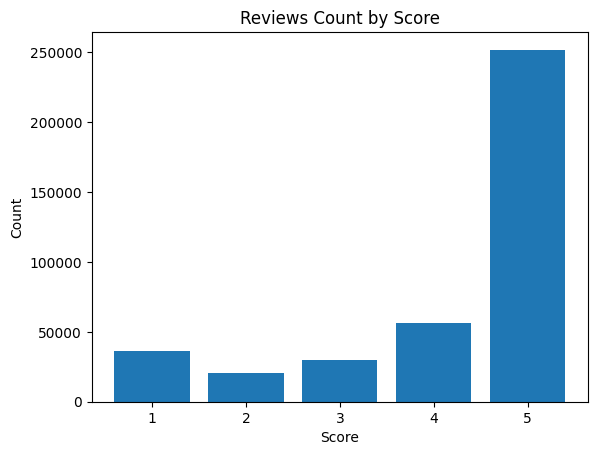

In [13]:
plt_Score = plt.bar(df_Score['Score'], df_Score['Count'])
plt.title('Reviews Count by Score')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# using seaborn# 
# plt_Score = sns.countplot(data = df, x = 'Score', color='#1e72b0')
# plt_Score.set_xlabel('Score')
# plt_Score.set_ylabel('Count')
# plt_Score.set_title("Count of Reviews by Score")

### Feature analysis

In [14]:
#Split the dataset into positive and negative reviews
Sentiment=['Positive', 'Negative'] #, 'Neutral']
Count=[]
Frequency=[]

df_positive_reviews = df[df['Sentiment'] == 'Positive']
Count.append(len(df_positive_reviews))
Frequency.append((len(df_positive_reviews)/len(df)) * 100)

df_negative_reviews = df[df['Sentiment'] == 'Negative']
Count.append(len(df_negative_reviews))
Frequency.append((len(df_negative_reviews)/len(df)) * 100)

df_features = pd.DataFrame({'Sentiment': Sentiment, 'Count': Count, 'Frequency (%)': Frequency })
df_features

# Define a function to format the column with colored boxes and padding
def format_columns_with_color(val):
    color = f'rgba(255, {int(255 - val * 255)}, 0, 0.3)'
    margin = '2px'
    width = val # Adjust the width based on the Frequency
    
    # Check if the current value is the max or min value
    if val == df_features['Frequency (%)'].max():
        color = 'green'  # Change color for max value
    elif val == df_features['Frequency (%)'].min():
        color = 'red'   # Change color for min value
    
    return f'background-color: {color}; margin: {margin}; width: {width}%; display: flex;'

# Apply the styling function to the column
styled_df = df_features.style.applymap(format_columns_with_color, subset=['Frequency (%)']).format({'Frequency (%)': '{:.2f}%'})

# Display the styled DataFrame
display(styled_df)

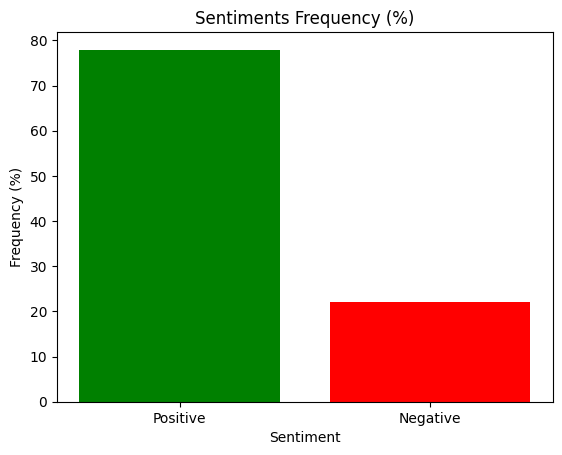

In [15]:
plt_Feature = plt.bar(df_features['Sentiment'], df_features['Frequency (%)'], color=['green','red'])
plt.title('Sentiments Frequency (%)')
plt.xlabel('Sentiment')
plt.ylabel('Frequency (%)')
plt.show()

In [16]:
# Limitting data to 100,000 rows
df = df.sample(n=100000, random_state=42)
#df = df[:100000]
df

Id   ProductId          UserId                 ProfileName  \
71536    71537  B007HIWJHU  A1U7BHSFWLE0OQ                     Xenadoc   
388700  388701  B002K5VL3S  A3KSP93KQ09NVP           Andrea E. Gulacsi   
433065  433066  B000SATIE6  A2WBNIRLWTCXIL      Eduardo Salazar "ESal"   
138014  138015  B000H226N0  A11M1LWQHJQRET  Edmond G. Bertrand "egb67"   
406935  406936  B0029JS264  A181XRGXAO6COB                  Lola Brown   
...        ...         ...             ...                         ...   
174764  174765  B007RTR8T8  A1A9Q3CQA5Y28E                 BurleysGirl   
456700  456701  B000UHE6YY  A1QCZAFD74W86A                      Shadow   
449323  449324  B001GVIRYS  A3P0Q6V7LDPGRM              Dr. "drrhonda"   
497352  497353  B005IOXR1M  A3JD0QYOI2MQP7               Connie M Hall   
272134  272135  B000J4IDP6  A2UAGIC8CLQ1KF                       Jen N   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
71536                      0                       0      5  1349740800   
388700                     0                       0      5  1338422400   
433065                     1                       2      5  1236643200   
138014                     0                       0      5  1272844800   
406935                     0                       1      1  1345507200   
...                      ...                     ...    ...         ...   
174764                     0                       0      3  1340323200   
456700                     0                       0      5  1340409600   
449323                     0                       0      5  1251244800   
497352                     0                       3      1  1320451200   
272134                     3                       7      2  1173657600   

                                 Summary  \
71536            Delicious low-cal snack   
388700                        Very Cute!   
433065         South African Rooibos tea   
138014            GOD, I LOVE THIS STUFF   
406935              too much maltitol...   
...                                  ...   
174764                       Not for me.   
456700                  Hard to find ...   
449323  Splenda, splenda everywhere . ..   
497352                              Weak   
272134                   Good but gritty   

                                                     Text Sentiment  \
71536   The perfect size for one.  Yummy and satisfyin...  Positive   
388700  I really liked these tea bags, they were great...  Positive   
433065  Great tasting tea and healthy.  Great price be...  Positive   
138014  OMG, this is such incredible stuff. Served hot...  Positive   
406935  These chips look like the real thing and they ...  Negative   
...                                                   ...       ...   
174764  I have thick, coarse, curly hair, and this pro...  Negative   
456700  Rediculously good, I am a big fan of Red Vines...  Positive   
449323  With Prime, Ship and Save and the size of the ...  Positive   
497352  I don't know what I expected when you add wate...  Negative   
272134  I bought two flavors of Gloria Jeans k-cups. I...  Negative   

        Sentiment_Int  
71536               1  
388700              1  
433065              1  
138014              1  
406935              0  
...               ...  
174764              0  
456700              1  
449323              1  
497352              0  
272134              0  

[100000 rows x 12 columns]

### Correlation Analysis

Text(0.5, 1.0, 'Correlation Matrix')

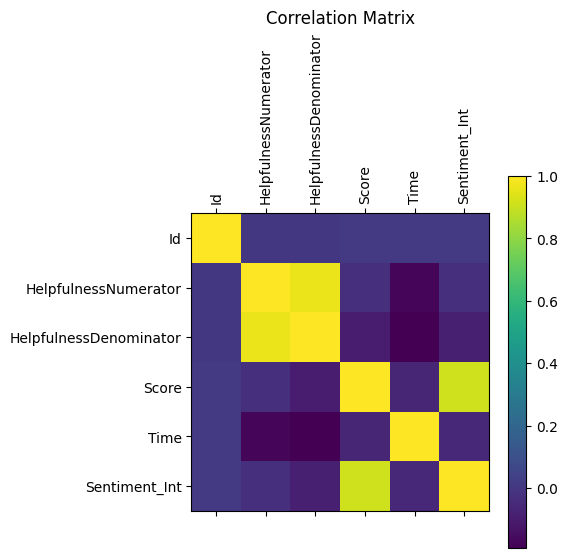

In [17]:
plt.matshow(df.corr())
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Correlation Matrix')

## Preprocessing Data

In [18]:
# 100 character of 10 reviews
for index, row in df[:10].iterrows():
    print(index, "  ", row['Text'][:100])

71536    The perfect size for one.  Yummy and satisfying TV snack that won't bust your diet.  This box has fo
388700    I really liked these tea bags, they were great to serve at the end of a party and everyone loved the
433065    Great tasting tea and healthy.  Great price being organic.  It taste wonderful as iced tea w/lemon  
138014    OMG, this is such incredible stuff. Served hot during the winter, with just a bit of milk and sugar,
406935    These chips look like the real thing and they taste alright but there is simply too much maltitol in
387550    Strong, bold, rich taste. Great with 12 oz cup. This item has recently been unavailable on Amazon, s
437300    These are available for much less at our local grocer.<br />Seems like purchasing volume would make 
148645    If you choose to have this salty/sugary snack bar, which is basically a candy bar, fix yourself a ju
496394    This is my go-to hot cocoa beverage for winter.  Very tasty and, yes, a bit decadent if you're watch
30

In [19]:
# 100 character of 10 positive reviews
for index, row in df_positive_reviews[:10].iterrows():
    print(index, "  ", row['Text'][:100])

150528    In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br /
150506    This is a fun way for children to learn their months of the year!  We will learn all of the poems th
150505    I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, an
150504    Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended 
150503    A very entertaining rhyming story--cleaver and catchy.The illustrations are imaginative and fit righ
150502    This is my grand daughter's and my favorite book to read. She is 4 and loves the rhythm of this cute
150501    This copy is smaller than I expected (mostly because I didn't pay attention to the listed dimensions
150500    I can remember seeing the show when it aired on television years ago, when I was a child.  My sister
150498    This book has been a favorite of mine since I was able to read. It was one of my first introductions
1

In [20]:
# 100 character of 10 Negative reviews
for index, row in df_negative_reviews[:10].iterrows():
    print(index, "  ", row['Text'][:100])

150496    I give five stars to the Maurice Sendak story. One star for this printed edition of the book.<br />M
150494    When I ordered a large amount of these books to share with child care providers, I was greatly disap
150527    This book was purchased to be used in a classroom setting for read-a-loud purposes.  The small size 
150526    It was a great price, but I can't read it to my class. It is like a little travel brochure.
150525    This is one of the best children's books ever written but it is a mini version of the book and was n
24749    My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very 
171185    Same price as Dr. Foster & Smith.
171189    My dog enjoys these treats in moderation.  Because they are dried, he seems to enjoy them less the m
171190    These are great training treats when you need something lightweight that won't make a mess of your p
171249    I must say that my dog and all at the dog park LOVE these treats. Ev

### Removing special characters and converting to lower case

In [21]:
# Remove punctuation and specific characters
df['Text'] = df['Text'].apply(str).map(lambda x: re.sub('[?|!|\'|"|#|.|,|)|(|\|/]', '', x))

# Remove HTML tags
df['Text'] = df['Text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

# Convert the titles to lowercase
df['Text'] = df['Text'].apply(str).map(lambda x: x.lower())

In [22]:
# 100 character of 10 cheaned reviews
for index, row in df[:10].iterrows():
    print(index, "  ", row['Text'][:100])

71536    the perfect size for one  yummy and satisfying tv snack that wont bust your diet  this box has four 
388700    i really liked these tea bags they were great to serve at the end of a party and everyone loved them
433065    great tasting tea and healthy  great price being organic  it taste wonderful as iced tea wlemon  & s
138014    omg this is such incredible stuff served hot during the winter with just a bit of milk and sugar it 
406935    these chips look like the real thing and they taste alright but there is simply too much maltitol in
387550    strong bold rich taste great with 12 oz cup this item has recently been unavailable on amazon so if 
437300    these are available for much less at our local grocerseems like purchasing volume would make this a 
148645    if you choose to have this saltysugary snack bar which is basically a candy bar fix yourself a jug o
496394    this is my go-to hot cocoa beverage for winter  very tasty and yes a bit decadent if youre watching 
30

### Tokenisation

In [23]:
def sentence_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False)) # deacc=True removes punctuations

In [24]:
data = df['Text'].tolist()
data_words = list(sentence_to_words(data))
print('data_words[:1]', data_words[:1])

data_words[:1] [['the', 'perfect', 'size', 'for', 'one', 'yummy', 'and', 'satisfying', 'tv', 'snack', 'that', 'wont', 'bust', 'your', 'diet', 'this', 'box', 'has', 'four', 'individual', 'bags', 'each', 'takes', 'about', 'minutes', 'to', 'micro']]


### Unigrams, bigrams and trigrams

In [25]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

'''
    min_count=5: 
    This parameter specifies the minimum frequency of a phrase in the corpus for it to be considered as a candidate 
    for merging. Phrases that occur fewer than min_count times will not be considered. 
    Increasing this parameter will lead to fewer bigrams.
    
    threshold:
    Represent a score threshold for forming the phrases (higher means fewer phrases). 
    A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. 
    Heavily depends on concrete scoring-function, see the scoring parameter.
'''

print('bigram', bigram)
print('bigram data', bigram[data_words])
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
print('trigram', trigram)

bigram Phrases<1421736 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
bigram data <gensim.interfaces.TransformedCorpus object at 0x000001D81BF80D88>
trigram Phrases<1459428 vocab, min_count=5, threshold=100, max_vocab_size=40000000>


In [26]:
# Faster way to get a sentence clubbed as a trigram/bigram

# is a step that converts the bigram model created using gensim.models.Phrases into an efficient binary format, called a "phraser".
bigram_mod = gensim.models.phrases.Phraser(bigram) 
trigram_mod = gensim.models.phrases.Phraser(trigram)
bigram_mod.save("bigram_mod") # save to file
trigram_mod.save("trigram_mod")
bigram_mod = gensim.models.Phrases.load("bigram_mod") # reload
trigram_mod = gensim.models.Phrases.load("trigram_mod")
# save and reload are optional

In [27]:
for bigram in bigram_mod.phrasegrams.keys():
    print(bigram)

agave_nectar
root_beer
low_carbing
old_fashioned
peanut_butter
sweet_tooth
ice_cream
valentines_day
lentil_curry
act_ii
grocery_store
gluten_free
bobs_red
red_mill
health_conscious
riboflavin_niacin
pantothenic_acid
proprietary_blend
red_bull
watered_down
high_hopes
freshly_ground
skim_milk
canyon_creek
pleasantly_surprised
shelf_stable
high_fructose
fructose_corn
olive_oil
melitta_cafe
stand_alone
family_members
chicken_tenders
green_mountain
trader_joes
stopped_carrying
reasonably_priced
wont_regret
stopped_selling
highly_recommend
red_rain
energy_boost
highly_recommended
blown_away
picky_eaters
medium_roast
co_workers
outer_layer
keurig_brewer
stir_fry
toaster_oven
basmati_rice
indian_restaurants
full_disclosure
human_grade
picky_eater
baked_goods
bloody_mary
low_carb
yr_old
window_sill
blue_buffalo
buffalo_wilderness
lost_lbs
pie_crust
room_temperature
rolling_pin
xanthan_gum
white_cheddar
full_bodied
nutritional_value
mashed_potatoes
net_carbs
egg_whites
years_ago
pop_tarts
huge_f

In [28]:
for trigram in trigram_mod.phrasegrams.keys():
    print(trigram)

agave_nectar
root_beer
low_carbing
old_fashioned
peanut_butter
sweet_tooth
ice_cream
valentines_day
lentil_curry
act_ii
shipped_promptly
grocery_store
gluten_free
bobs_red
bobs_red_mill
health_conscious
riboflavin_niacin
proprietary_blend
red_bull
depending_upon
watered_down
high_hopes
freshly_ground
skim_milk
canyon_creek
pleasantly_surprised
shelf_stable
high_fructose
olive_oil
melitta_cafe
stand_alone
family_members
chicken_tenders
green_mountain
trader_joes
stopped_carrying
reasonably_priced
wont_regret
stopped_selling
highly_recommend
red_rain
zero_calorie
energy_boost
hour_energy
highly_recommended
blown_away
picky_eaters
medium_roast
dark_roast
co_workers
outer_layer
keurig_brewer
stir_fry
toaster_oven
basmati_rice
indian_restaurants
year_old
full_disclosure
human_grade
picky_eater
baked_goods
bloody_mary
stay_away
low_carb
yr_old
window_sill
blue_buffalo
blue_buffalo_wilderness
lost_lbs
pie_crust
palm_oil
room_temperature
rolling_pin
grocery_stores
xanthan_gum
sour_cream
white_

### Lemmatisation and stop words

In [29]:
my_stop_words = STOPWORDS.union(set(['br']))

# Define functions for stopwords, bigrams, trigrams and lemmatisation
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in my_stop_words] for doc in texts]

In [30]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [31]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [32]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [33]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# It loads the spaCy English language model 'en_core_web_sm' with specific components disabled.
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print('data_lemmatized[:1]', data_lemmatized[:1])

data_lemmatized[:1] [['perfect', 'size', 'yummy', 'satisfy', 'tv', 'snack', 'bag', 'take', 'minute', 'micro']]


In [34]:
# Add CleanedText column to df
CleandText = []
for words_list in data_lemmatized:
    #querywords = query.split()
    resultwords  = [word for word in words_list]
    result = ' '.join(resultwords)
    CleandText.append(result)

df['CleanedText'] = CleandText
df

Id   ProductId          UserId                 ProfileName  \
71536    71537  B007HIWJHU  A1U7BHSFWLE0OQ                     Xenadoc   
388700  388701  B002K5VL3S  A3KSP93KQ09NVP           Andrea E. Gulacsi   
433065  433066  B000SATIE6  A2WBNIRLWTCXIL      Eduardo Salazar "ESal"   
138014  138015  B000H226N0  A11M1LWQHJQRET  Edmond G. Bertrand "egb67"   
406935  406936  B0029JS264  A181XRGXAO6COB                  Lola Brown   
...        ...         ...             ...                         ...   
174764  174765  B007RTR8T8  A1A9Q3CQA5Y28E                 BurleysGirl   
456700  456701  B000UHE6YY  A1QCZAFD74W86A                      Shadow   
449323  449324  B001GVIRYS  A3P0Q6V7LDPGRM              Dr. "drrhonda"   
497352  497353  B005IOXR1M  A3JD0QYOI2MQP7               Connie M Hall   
272134  272135  B000J4IDP6  A2UAGIC8CLQ1KF                       Jen N   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
71536                      0                       0      5  1349740800   
388700                     0                       0      5  1338422400   
433065                     1                       2      5  1236643200   
138014                     0                       0      5  1272844800   
406935                     0                       1      1  1345507200   
...                      ...                     ...    ...         ...   
174764                     0                       0      3  1340323200   
456700                     0                       0      5  1340409600   
449323                     0                       0      5  1251244800   
497352                     0                       3      1  1320451200   
272134                     3                       7      2  1173657600   

                                 Summary  \
71536            Delicious low-cal snack   
388700                        Very Cute!   
433065         South African Rooibos tea   
138014            GOD, I LOVE THIS STUFF   
406935              too much maltitol...   
...                                  ...   
174764                       Not for me.   
456700                  Hard to find ...   
449323  Splenda, splenda everywhere . ..   
497352                              Weak   
272134                   Good but gritty   

                                                     Text Sentiment  \
71536   the perfect size for one  yummy and satisfying...  Positive   
388700  i really liked these tea bags they were great ...  Positive   
433065  great tasting tea and healthy  great price bei...  Positive   
138014  omg this is such incredible stuff served hot d...  Positive   
406935  these chips look like the real thing and they ...  Negative   
...                                                   ...       ...   
174764  i have thick coarse curly hair and this produc...  Negative   
456700  rediculously good i am a big fan of red vines ...  Positive   
449323  with prime ship and save and the size of the b...  Positive   
497352  i dont know what i expected when you add water...  Negative   
272134  i bought two flavors of gloria jeans k-cups i ...  Negative   

        Sentiment_Int                                        CleanedText  
71536               1  perfect size yummy satisfy tv snack bag take m...  
388700              1                like tea bag great serve party love  
433065              1  great taste tea healthy great price organic ta...  
138014              1  omg incredible stuff serve hot winter bit milk...  
406935              0  chip look real thing taste simply maltitol esp...  
...               ...                                                ...  
174764              0  coarse curly_hair product result hair soft sti...  
456700              1  rediculously good big fan red_vine perfect lov...  
449323              1  prime ship save size bag cost beat love come r...  
497352              0    know expect add water apple weak taste cinnamon  
272134         

In [35]:
# Tokenize the text and count the occurrence of each word in positive reviews
positive_words = ' '.join(df[df['Sentiment'] == 'Positive']).split()
#positive_word_counts = pd.Series(positive_words).value_counts()

In [36]:
# Tokenize the text and count the occurrence of each word in negative reviews
negative_words = ' '.join(df[df['Sentiment'] == 'Negative']).split()
negative_word_counts = pd.Series(negative_words).value_counts()

In [37]:
positive_reviews = df[df['Sentiment'] == 'Positive']
negative_reviews = df[df['Sentiment'] == 'Negative']

# Feature extraction
# Tokenize the text and count the occurrence of each word in positive reviews
positive_words = ' '.join(positive_reviews['CleanedText']).split()
positive_word_counts = pd.Series(positive_words).value_counts()

# Tokenize the text and count the occurrence of each word in negative reviews
negative_words = ' '.join(negative_reviews['CleanedText']).split()
negative_word_counts = pd.Series(negative_words).value_counts()

# The most common words in positive and negative reviews
print(f"The most common words in positive reviews: \n\n{positive_word_counts}")
print()
print(f"The Most common words in negative reviews: \n{negative_word_counts}")

The most common words in positive reviews: 

good           35257
taste          30325
great          25459
flavor         25327
love           24497
               ...  
diplomacy          1
saltless           1
kenzi              1
basketgreat        1
preium             1
Length: 63204, dtype: int64

The Most common words in negative reviews: 
taste           12957
product          9986
flavor           8201
good             7690
buy              7284
                ...  
cheaperwhile        1
writtenon           1
corps               1
conical             1
crisphowever        1
Length: 32100, dtype: int64


## Frequency and Visualisation

In [38]:
def getWordCloud(hashtags):
    # Read the whole text.
    text = ' '.join(hashtags)
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('wordcloud_all.pdf', dpi=500)
    plt.show()

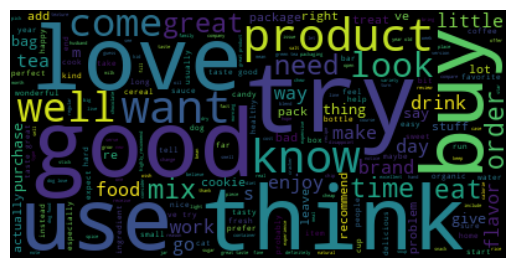

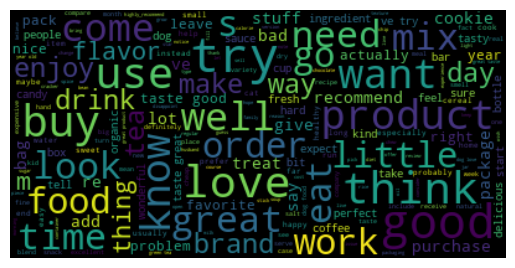

In [39]:
s = []
for l in data_lemmatized:
    t = ' '.join(l)
    s.append(t)
getWordCloud(s)

In [138]:
# Define needed parameters
accuracy_list=[]
precision_list=[]
recall_list=[]
fscore_list=[]
alpha_list=[]
model_list=[]

# Split the dataset into training and testing sets
X = df['CleanedText']
Y = df['Sentiment']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Feature Engineering

In [139]:
def create_feature_engineering(model_Type):
    '''
        According to the input, the vectorizer is created
    '''
    
    print(f"The model name is {model_Type}\n")
    if model_Type == 'TF-IDF':        
        vectorizer = TfidfVectorizer()
    elif model_Type == 'Bi-Grams':
        vectorizer = TfidfVectorizer(ngram_range=(1,2))
    elif model_Type == 'Tri-Grams':
        vectorizer = TfidfVectorizer(ngram_range=(2,3))
    elif model_Type == 'BoW':
        vectorizer = CountVectorizer()
    else:
        return "Invalid model name."
    
    return vectorizer

## Traditional Machine Learning Methods/Models

## 1) Naive Bayes Classifier

In [140]:
def get_cofusion_matrix(y_test, y_pred):
    '''
        This fuction plots the Confusion matrix. This calculates and prints TP, TN, FP, and FN values
    '''
    
    # Plot confusion_matrix
    display_labels = ['Positive', 'Negative']
    con_mat = confusion_matrix(y_test, y_pred, labels = display_labels)
    ax = plt.axes()
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix = con_mat, display_labels = display_labels)
    disp.plot(ax = ax)
    plt.show()    
    
    # Print the Conclusions on the trained dataset
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    positive_count = TP + FN
    negative_count = FP + TN
    
    TPR = TP / positive_count
    TNR = TN / negative_count
    FPR = FP / negative_count
    FNR = FN / positive_count
    
    print("*** The Confusion Matrix Information ***")
    print("The True Positives Rate: {}".format(TPR))
    print("The True Negatives Rate: {}".format(TNR))
    print("The False Positives Rate: {}".format(FPR))
    print("The False Negatives Rate: {}".format(FNR))

In [141]:
def get_evaluation(y_test, y_pred):
    '''
        This fuction calcualates accuracy_score, precision_score, recall_score, and f1_score according to the input values
    '''
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(str(round(accuracy, 2)))
    print(f"Accuracy = {accuracy : .2f}")

    # Calculate precision
    precision = precision_score(y_test, y_pred, average='weighted')
    precision_list.append(str(round(precision, 2)))
    print(f"Precision = {precision : .2f}")

    # Calculate recall
    recall = recall_score(y_test, y_pred, average='weighted')
    recall_list.append(str(round(recall, 2)))
    print(f"Recall = {recall : .2f}")
    
    # Calculate f1_score
    f_score = f1_score(y_test, y_pred, average='weighted')
    fscore_list.append(str(round(f_score, 2)))
    print(f"F1_score = {f_score : .2f}\n")
    
    # Display the classification reportabs
    print("*** The classification_report ***")
    print(classification_report(y_test, y_pred))

In [142]:
def create_naive_bayes_model(model_Type):
    '''
        This function creates Naive Bayes Model according to the name of feature engineering from input
        The results are predicted and evaluated
    '''
    
    # Call method to create a vectorizer    
    vectorizer = create_feature_engineering(model_Type)
        
    # fitting
    x_train_vect = vectorizer.fit_transform(x_train)
    x_test_vect = vectorizer.transform(x_test)
    
    # Create the model
    classifier_NB = MultinomialNB()
        
    # Training
    classifier_NB.fit(x_train_vect, y_train)
    
    # Predictiction
    y_pred = classifier_NB.predict(x_test_vect)
    
    # Evaluateion
    print("*** The Evaluation of the Model ***")
    get_evaluation(y_test, y_pred)
    
    # Display confusion matrix
    get_cofusion_matrix(y_test, y_pred)
    alpha_list.append('-')

In [143]:
def create_naive_bayes_model_hyperparameter_tuning (model_Type):
    '''
        This method creates Naive Bayes Model according to the name of feature engineering from input
        It gets the best alpha value for hypertuning parameters
        It uses the best hyperparameters to train the final model
        The results are predicted and evaluated
    '''
    
    # Call method to create a vectorizer
    vectorizer = create_feature_engineering(model_Type)
    
    # Fitting
    x_train_vect = vectorizer.fit_transform(x_train)
    x_test_vect = vectorizer.transform(x_test)
    
    # Create the model
    classifier_NB = MultinomialNB()
    
    # Define hyperparameters to tune
    param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}
    
    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(estimator=classifier_NB, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train_vect, y_train)
    
    # Get the best hyperparameters
    best_alpha = grid_search.best_params_['alpha']
    alpha_list.append(best_alpha)
    print(f"Best alpha value: {best_alpha}\n")
    
    # Use the best hyperparameters to train the final model
    classifier_NB = MultinomialNB(alpha=best_alpha)
    classifier_NB.fit(x_train_vect, y_train)
    
    # Predictiction
    y_pred = classifier_NB.predict(x_test_vect)
    
    # Evaluation
    print("*** The Evaluation of the Model ***")
    get_evaluation(y_test, y_pred)
    
    # Display confusion matrix
    get_cofusion_matrix(y_test, y_pred)

In [144]:
def create_naive_bayes_model_hyperparameter_tuning_SMOTE(model_Type):
    '''
        This function creates Naive Bayes Model according to the name of feature engineering from input
        The SMOTE is applied for balancing the dataset
        It gets the best alpha value for hypertuning parameters
        It uses the best hyperparameters to train the final model
        The results are predicted and evaluated
    '''

    # Call method to create a vectorizer
    vectorizer = create_feature_engineering(model_Type)
    
    # Fitting
    x_train_vect = vectorizer.fit_transform(x_train)
    x_test_vect = vectorizer.transform(x_test)
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train_vect, y_train)
    
    # Create the model
    classifier_NB = MultinomialNB()
    
    # Define hyperparameters to tune
    param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}
    
    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(estimator=classifier_NB, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train_resampled, y_train_resampled)
    
    # Get the best hyperparameters
    best_alpha = grid_search.best_params_['alpha']
    alpha_list.append(best_alpha)
    print(f"Best alpha value: {best_alpha}\n")
    
    # Use the best hyperparameters to train the final model
    classifier_NB = MultinomialNB(alpha=best_alpha)
    classifier_NB.fit(x_train_resampled, y_train_resampled)
    
    # Predictiction
    y_pred = classifier_NB.predict(x_test_vect)
    
    # Evaluation
    print("*** The Evaluation of the Model ***")
    get_evaluation(y_test, y_pred)
    
    # Display confusion matrix
    get_cofusion_matrix(y_test, y_pred)

### TF-IDF model

The model name is TF-IDF

*** The Evaluation of the Model ***
Accuracy =  0.79
Precision =  0.83
Recall =  0.79
F1_score =  0.70

*** The classification_report ***
              precision    recall  f1-score   support

    Negative       0.98      0.03      0.06      4409
    Positive       0.78      1.00      0.88     15591

    accuracy                           0.79     20000
   macro avg       0.88      0.52      0.47     20000
weighted avg       0.83      0.79      0.70     20000



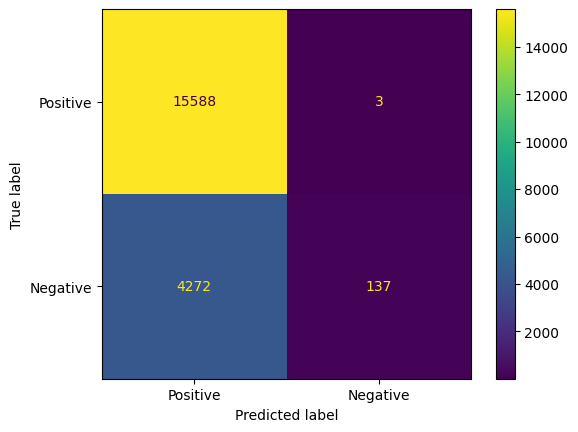

*** The Confusion Matrix Information ***
The True Positives Rate: 0.9998075812969021
The True Negatives Rate: 0.031072805624858243
The False Positives Rate: 0.9689271943751417
The False Negatives Rate: 0.00019241870309794111


In [145]:
create_naive_bayes_model('TF-IDF')
model_list.append('TF-IDF')

### Apply Hyperparameter Tuning

The model name is TF-IDF

Best alpha value: 0.1

*** The Evaluation of the Model ***
Accuracy =  0.82
Precision =  0.83
Recall =  0.82
F1_score =  0.78

*** The classification_report ***
              precision    recall  f1-score   support

    Negative       0.84      0.25      0.38      4409
    Positive       0.82      0.99      0.90     15591

    accuracy                           0.82     20000
   macro avg       0.83      0.62      0.64     20000
weighted avg       0.83      0.82      0.78     20000



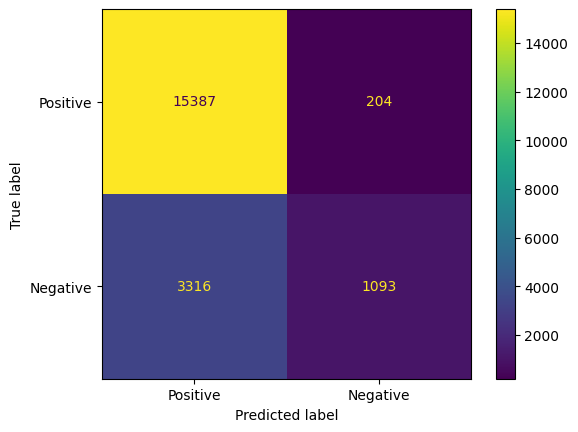

*** The Confusion Matrix Information ***
The True Positives Rate: 0.98691552818934
The True Negatives Rate: 0.24790201859832162
The False Positives Rate: 0.7520979814016784
The False Negatives Rate: 0.013084471810659996


In [146]:
create_naive_bayes_model_hyperparameter_tuning('TF-IDF')
model_list.append('TF-IDF Hypertunning')

### Apply Hyperparameter Tuning and SMOTE

In [ ]:
create_naive_bayes_model_hyperparameter_tuning_SMOTE('TF-IDF')
model_list.append('TF-IDF Hypertunning & SMOTE')

### Bi-Grams model

The model name is Bi-Grams

*** The Evaluation of the Model ***
Accuracy =  0.78
Precision =  0.83
Recall =  0.78
F1_score =  0.68

*** The classification_report ***
              precision    recall  f1-score   support

    Negative       1.00      0.00      0.00      4409
    Positive       0.78      1.00      0.88     15591

    accuracy                           0.78     20000
   macro avg       0.89      0.50      0.44     20000
weighted avg       0.83      0.78      0.68     20000



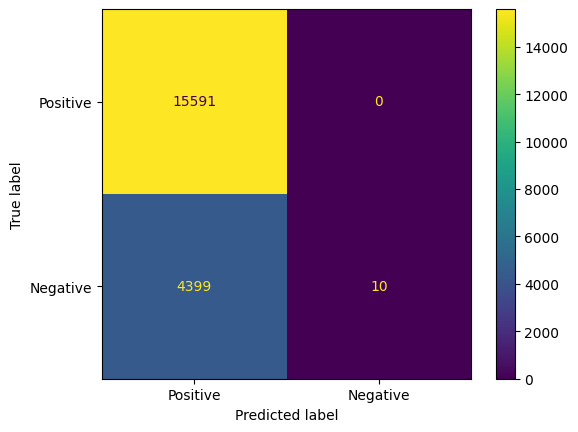

*** The Confusion Matrix Information ***
The True Positives Rate: 1.0
The True Negatives Rate: 0.0022680880018144706
The False Positives Rate: 0.9977319119981856
The False Negatives Rate: 0.0


In [148]:
create_naive_bayes_model('Bi-Grams')
model_list.append('Bi-Grams')

### Apply Hyperparameter Tuning

The model name is Bi-Grams

Best alpha value: 0.1

*** The Evaluation of the Model ***
Accuracy =  0.82
Precision =  0.83
Recall =  0.82
F1_score =  0.76

*** The classification_report ***
              precision    recall  f1-score   support

    Negative       0.92      0.18      0.30      4409
    Positive       0.81      1.00      0.89     15591

    accuracy                           0.82     20000
   macro avg       0.86      0.59      0.60     20000
weighted avg       0.83      0.82      0.76     20000



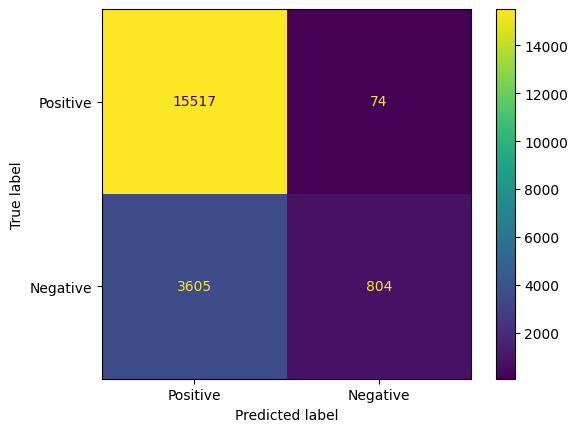

*** The Confusion Matrix Information ***
The True Positives Rate: 0.9952536719902508
The True Negatives Rate: 0.18235427534588342
The False Positives Rate: 0.8176457246541166
The False Negatives Rate: 0.004746328009749215


In [149]:
create_naive_bayes_model_hyperparameter_tuning('Bi-Grams')
model_list.append('Bi-Grams Hypertunning')

### Apply Hyperparameter Tuning and SMOTE

The model name is Bi-Grams

Best alpha value: 0.1

*** The Evaluation of the Model ***
Accuracy =  0.85
Precision =  0.85
Recall =  0.85
F1_score =  0.85

*** The classification_report ***
              precision    recall  f1-score   support

    Negative       0.67      0.63      0.65      4409
    Positive       0.90      0.91      0.91     15591

    accuracy                           0.85     20000
   macro avg       0.79      0.77      0.78     20000
weighted avg       0.85      0.85      0.85     20000



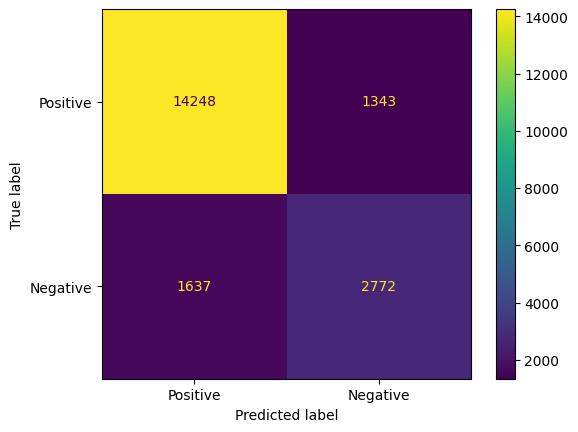

*** The Confusion Matrix Information ***
The True Positives Rate: 0.9138605605798217
The True Negatives Rate: 0.6287139941029712
The False Positives Rate: 0.3712860058970288
The False Negatives Rate: 0.08613943942017831


In [150]:
create_naive_bayes_model_hyperparameter_tuning_SMOTE('Bi-Grams')
model_list.append('Bi-Grams Hypertunning & SMOTE')

### Tri-Grams model

The model name is Tri-Grams

*** The Evaluation of the Model ***
Accuracy =  0.78
Precision =  0.83
Recall =  0.78
F1_score =  0.68

*** The classification_report ***
              precision    recall  f1-score   support

    Negative       1.00      0.00      0.01      4409
    Positive       0.78      1.00      0.88     15591

    accuracy                           0.78     20000
   macro avg       0.89      0.50      0.44     20000
weighted avg       0.83      0.78      0.68     20000



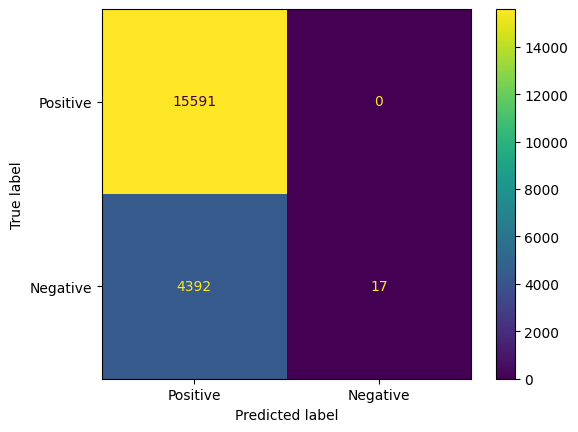

*** The Confusion Matrix Information ***
The True Positives Rate: 1.0
The True Negatives Rate: 0.0038557496030845995
The False Positives Rate: 0.9961442503969155
The False Negatives Rate: 0.0


In [151]:
create_naive_bayes_model('Tri-Grams')
model_list.append('Tri-Grams')

### Apply Hyperparameter Tuning

The model name is Tri-Grams

Best alpha value: 0.5

*** The Evaluation of the Model ***
Accuracy =  0.78
Precision =  0.83
Recall =  0.78
F1_score =  0.69

*** The classification_report ***
              precision    recall  f1-score   support

    Negative       0.99      0.02      0.03      4409
    Positive       0.78      1.00      0.88     15591

    accuracy                           0.78     20000
   macro avg       0.88      0.51      0.45     20000
weighted avg       0.83      0.78      0.69     20000



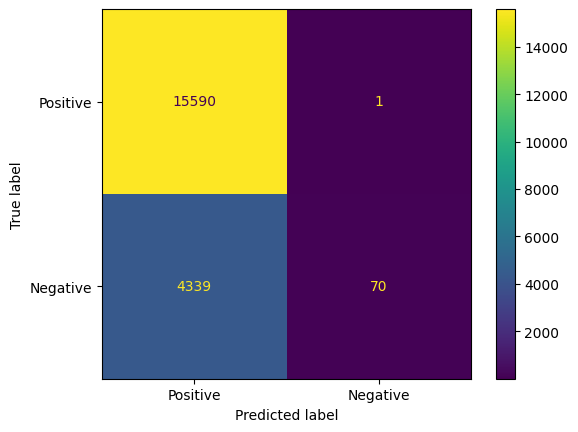

*** The Confusion Matrix Information ***
The True Positives Rate: 0.9999358604323006
The True Negatives Rate: 0.015876616012701295
The False Positives Rate: 0.9841233839872987
The False Negatives Rate: 6.413956769931371e-05


In [152]:
create_naive_bayes_model_hyperparameter_tuning('Tri-Grams')
model_list.append('Tri-Grams Hypertunning')

### Apply Hyperparameter Tuning and SMOTE

The model name is Tri-Grams

Best alpha value: 2.0

*** The Evaluation of the Model ***
Accuracy =  0.85
Precision =  0.84
Recall =  0.85
F1_score =  0.84

*** The classification_report ***
              precision    recall  f1-score   support

    Negative       0.68      0.58      0.62      4409
    Positive       0.89      0.92      0.90     15591

    accuracy                           0.85     20000
   macro avg       0.78      0.75      0.76     20000
weighted avg       0.84      0.85      0.84     20000



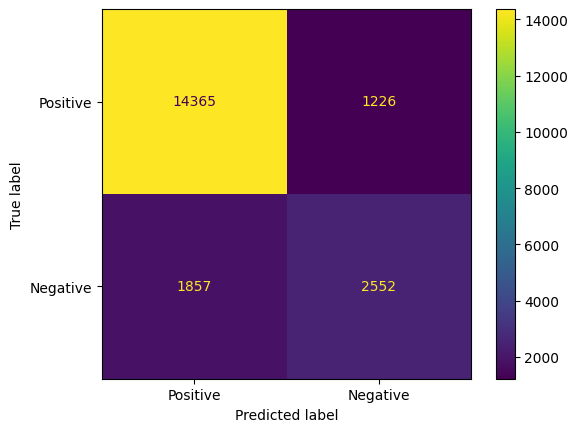

*** The Confusion Matrix Information ***
The True Positives Rate: 0.9213648900006414
The True Negatives Rate: 0.5788160580630528
The False Positives Rate: 0.42118394193694714
The False Negatives Rate: 0.0786351099993586


In [153]:
create_naive_bayes_model_hyperparameter_tuning_SMOTE('Tri-Grams')
model_list.append('Tri-Grams Hypertunning & SMOTE')

### Bag-of-Words model

The model name is BoW

*** The Evaluation of the Model ***
Accuracy =  0.86
Precision =  0.85
Recall =  0.86
F1_score =  0.85

*** The classification_report ***
              precision    recall  f1-score   support

    Negative       0.76      0.52      0.62      4409
    Positive       0.87      0.95      0.91     15591

    accuracy                           0.86     20000
   macro avg       0.82      0.74      0.76     20000
weighted avg       0.85      0.86      0.85     20000



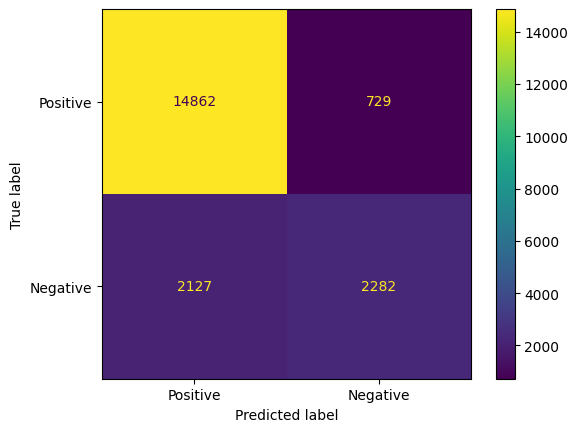

*** The Confusion Matrix Information ***
The True Positives Rate: 0.9532422551472003
The True Negatives Rate: 0.5175776820140622
The False Positives Rate: 0.4824223179859379
The False Negatives Rate: 0.04675774485279969


In [154]:
create_naive_bayes_model('BoW')
model_list.append('Bag-of-Words')

### Apply Hyperparameter Tuning

The model name is BoW

Best alpha value: 1.0

*** The Evaluation of the Model ***
Accuracy =  0.86
Precision =  0.85
Recall =  0.86
F1_score =  0.85

*** The classification_report ***
              precision    recall  f1-score   support

    Negative       0.76      0.52      0.62      4409
    Positive       0.87      0.95      0.91     15591

    accuracy                           0.86     20000
   macro avg       0.82      0.74      0.76     20000
weighted avg       0.85      0.86      0.85     20000



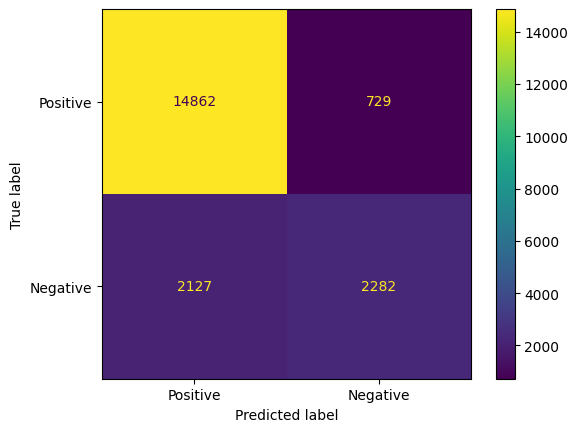

*** The Confusion Matrix Information ***
The True Positives Rate: 0.9532422551472003
The True Negatives Rate: 0.5175776820140622
The False Positives Rate: 0.4824223179859379
The False Negatives Rate: 0.04675774485279969


In [155]:
create_naive_bayes_model_hyperparameter_tuning('BoW')
model_list.append('Bag-of-Words Hypertunning')

### Apply Hyperparameter Tuning and SMOTE

The model name is BoW

Best alpha value: 0.5

*** The Evaluation of the Model ***
Accuracy =  0.82
Precision =  0.83
Recall =  0.82
F1_score =  0.83

*** The classification_report ***
              precision    recall  f1-score   support

    Negative       0.58      0.69      0.63      4409
    Positive       0.91      0.86      0.88     15591

    accuracy                           0.82     20000
   macro avg       0.74      0.77      0.76     20000
weighted avg       0.83      0.82      0.83     20000



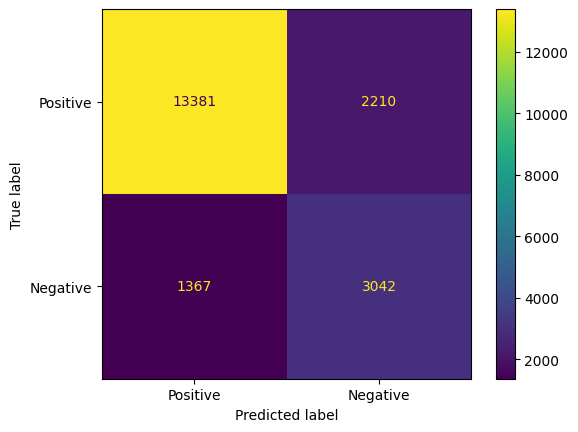

*** The Confusion Matrix Information ***
The True Positives Rate: 0.8582515553845167
The True Negatives Rate: 0.6899523701519619
The False Positives Rate: 0.31004762984803813
The False Negatives Rate: 0.1417484446154833


In [156]:
create_naive_bayes_model_hyperparameter_tuning_SMOTE('BoW')
model_list.append('Bag-of-Words Hypertunning & SMOTE')

## Results

In [157]:
# Create a dataframe to show all the evaluations results
df_naive_bayas_result = pd.DataFrame({'Model': model_list,
                                      'Best Alpha' : alpha_list,
                                      'Accuracy': accuracy_list,
                                      'Precision': precision_list,
                                      'Recall' : recall_list,
                                      'F1': fscore_list})
df_naive_bayas_result

Model Best Alpha Accuracy Precision Recall  \
0                              TF-IDF          -     0.79      0.83   0.79   
1                 TF-IDF Hypertunning        0.1     0.82      0.83   0.82   
2         TF-IDF Hypertunning & SMOTE        0.1     0.81      0.83   0.81   
3                            Bi-Grams          -     0.78      0.83   0.78   
4               Bi-Grams Hypertunning        0.1     0.82      0.83   0.82   
5       Bi-Grams Hypertunning & SMOTE        0.1     0.85      0.85   0.85   
6                           Tri-Grams          -     0.78      0.83   0.78   
7              Tri-Grams Hypertunning        0.5     0.78      0.83   0.78   
8      Tri-Grams Hypertunning & SMOTE        2.0     0.85      0.84   0.85   
9                        Bag-of-Words          -     0.86      0.85   0.86   
10          Bag-of-Words Hypertunning        1.0     0.86      0.85   0.86   
11  Bag-of-Words Hypertunning & SMOTE        0.5     0.82      0.83   0.82   

      F1  
0    0.7  
1   0.78  
2   0.81  
3   0.68  
4   0.76  
5   0.85  
6   0.68  
7   0.69  
8   0.84  
9   0.85  
10  0.85  
11  0.83

## 2) Clustering: K-means

In [61]:
def elbow_diagram(X_vect):
    '''
        It plots the elbow diagram
    '''
    
    SSE = [] # is the distance of the points from the cluster center
    for k in range(1, 10):
        kmeans = KMeans(n_clusters = k, random_state = 42)
        kmeans.fit(X_vect)
        intertia = kmeans.inertia_
        SSE.append(intertia)
        
    # plotting the number of clusters
    plot_df = pd.DataFrame({'Cluster' : range(1, 10), 'SSE' : SSE})
    plot_df
    
    plt.plot(plot_df['Cluster'], plot_df['SSE'])
    plt.plot('Cluster', 'SSE', 'b*', data = plot_df)
    plt.xlabel('Cluster', fontsize=20)
    plt.ylabel('SSE', fontsize = 20)

In [62]:
def print_cluster_top_terms(vectorizer, kmeans, k):
    '''
        The function prints the top terms per cluster
        
        vectorizer = tfidfVectorizer
        kmeans = K_means model
        k = number of clusters
    '''
    
    print("Top terms per cluster:")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(k):
        print(f"Cluster {i}:")
        for ind in order_centroids[i, :10]:
            print(f"{terms[ind]}")
        print()

In [63]:
def get_cluster_reviews_number(k):
    '''
        Gets the labels of each cluster
    '''
    
    clusters_dict = {i: np.where(labels == i)[0] for i in range(k)}
    # Transform this dictionary into list (if you need a list as result)
    clusters_list = []
    print("The number of reviews in each cluster are as follows : ")
    for key, value in clusters_dict.items():
        temp = [key, value]
        clusters_list.append(temp)
        print("Cluster = {}, Reviews Number = {}".format(key, len(value)))

In [64]:
def getWordCloud(vectorizer, kmeans, k):
    '''
        The function creates wordCloud
        vectorizer = tfidfVectorizer
        kmeans = K_means model
        k = number of clusters
    '''
    
    review_corpus = ""
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(k):
        review_corpus = ""
        for ind in order_centroids[i, :100]:
            review_str = terms[ind]
            review_corpus = review_corpus + " " + review_str
        
        # lower max_font_size
        wordcloud = WordCloud(prefer_horizontal=0.9, scale=1, max_words=75, min_font_size=4, random_state=42, repeat=False).generate(str(review_corpus))
        plt.title(f"Word Cloud: Cluster {i}")
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

### Using TF_IDF

The model name is TF-IDF



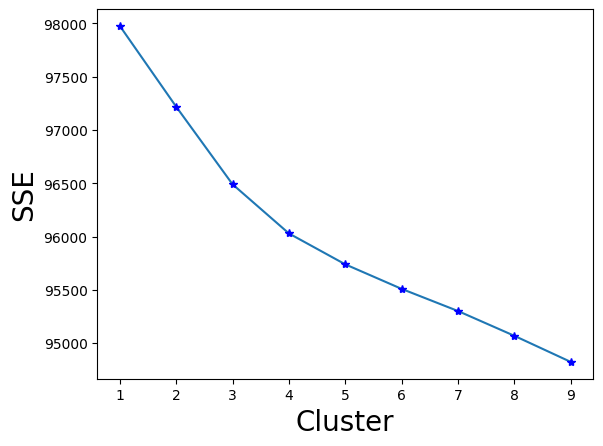

In [65]:
#vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=30000, dtype='float').fit(X)
vectorizer = create_feature_engineering('TF-IDF')
X_vect = vectorizer.fit_transform(X)
elbow_diagram(X_vect)

In [67]:
# fitting based on the number of optimal_k selected from the elbow diagram.
k = 4
kmeans = KMeans(n_clusters = k, random_state = 42)
kmeans.fit(X_vect)
labels = kmeans.predict(X_vect)
#print(labels)

In [68]:
#Print the top terms per cluster
print_cluster_top_terms(vectorizer, kmeans, k)

Top terms per cluster:
Cluster 0:
tea
flavor
drink
taste
green
good
bag
great
love
try

Cluster 1:
coffee
cup
flavor
taste
good
strong
great
try
drink
buy

Cluster 2:
dog
food
cat
treat
love
eat
product
good
feed
buy

Cluster 3:
good
taste
product
great
flavor
love
buy
try
order
eat



In [69]:
# get the labels of each cluster
get_cluster_reviews_number(k)

The number of reviews in each cluster are as follows : 
Cluster = 0, Reviews Number = 6316
Cluster = 1, Reviews Number = 8238
Cluster = 2, Reviews Number = 7563
Cluster = 3, Reviews Number = 77883


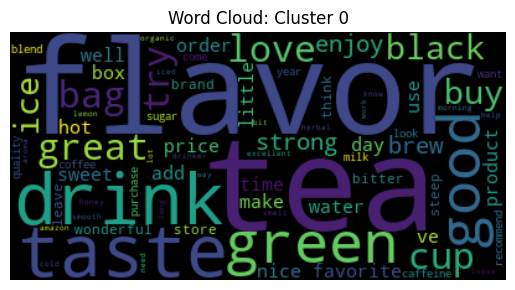

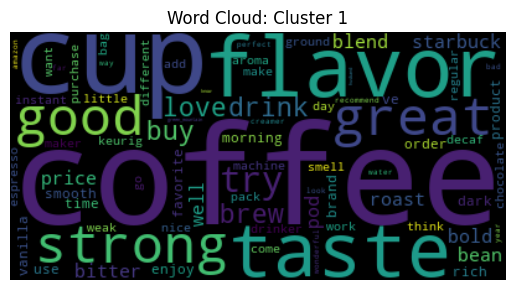

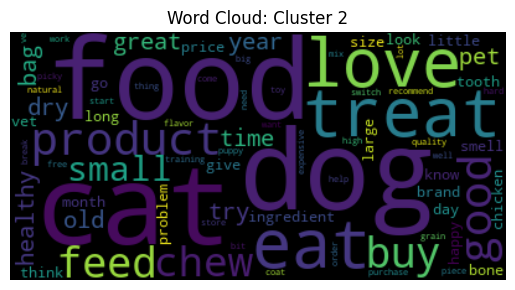

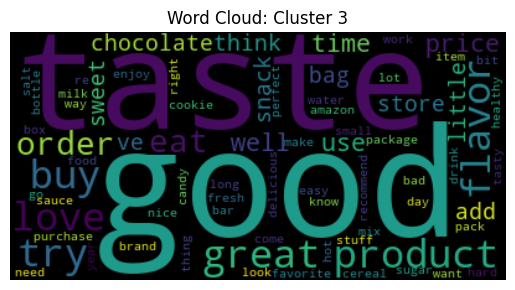

In [70]:
# Frequency and Visualisation
getWordCloud(vectorizer, kmeans, k)

In [71]:
#Evaluation
s_score = silhouette_score(X_vect, kmeans.labels_)
print(f"Silhouette Score: {s_score}")

Silhouette Score: 0.00848319278283226


In [72]:
## Compute davies_bouldin_score
#db_score = davies_bouldin_score(X_vect.toarray(), kmeans.labels_)
#print(f"davies_bouldin_score = {db_score:.2f}")

In [73]:
# Get the inertia (SSE)
inertia = kmeans.inertia_

print("Inertia (SSE):", inertia)

Inertia (SSE): 96029.06522309566


In [74]:
# fitting based on the number of optimal_k selected from the elbow diagram.
k = 7
kmeans = KMeans(n_clusters = k, random_state = 42)
kmeans.fit(X_vect)
labels = kmeans.predict(X_vect)
#print(labels)

In [75]:
#Print the top terms per cluster
print_cluster_top_terms(vectorizer, kmeans, k)

Top terms per cluster:
Cluster 0:
coffee
cup
flavor
taste
good
strong
great
try
drink
brew

Cluster 1:
order
product
good
time
great
love
receive
arrive
price
box

Cluster 2:
tea
flavor
green
drink
taste
good
bag
great
love
try

Cluster 3:
product
buy
good
great
love
use
price
try
taste
flavor

Cluster 4:
dog
treat
food
love
eat
chew
product
good
small
great

Cluster 5:
cat
food
eat
love
treat
can
dry
feed
product
good

Cluster 6:
taste
flavor
chocolate
good
bar
great
try
sweet
snack
cookie



In [76]:
# get the labels of each cluster
get_cluster_reviews_number(k)

The number of reviews in each cluster are as follows : 
Cluster = 0, Reviews Number = 7866
Cluster = 1, Reviews Number = 7316
Cluster = 2, Reviews Number = 6118
Cluster = 3, Reviews Number = 50929
Cluster = 4, Reviews Number = 5069
Cluster = 5, Reviews Number = 2254
Cluster = 6, Reviews Number = 20448


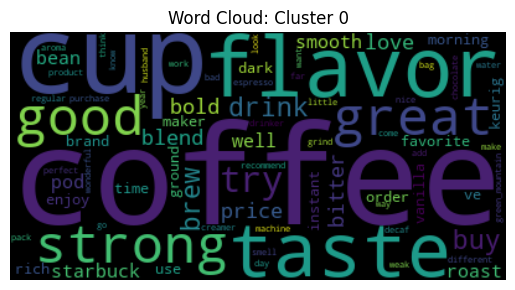

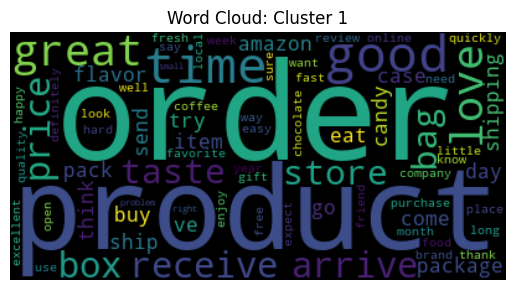

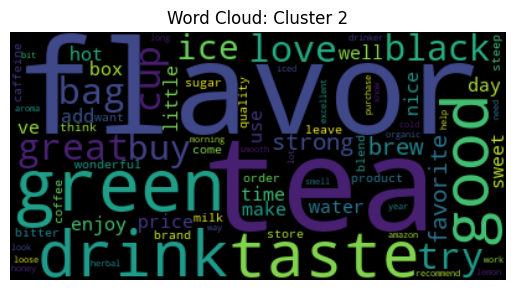

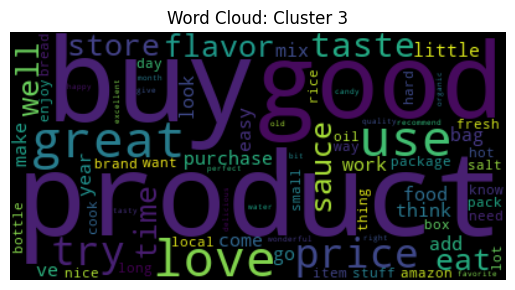

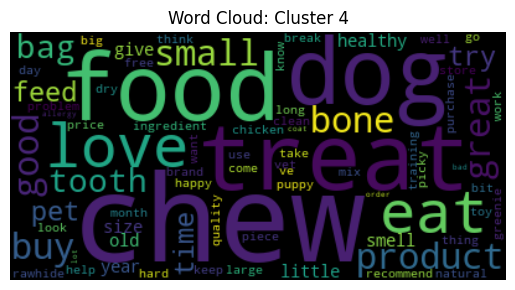

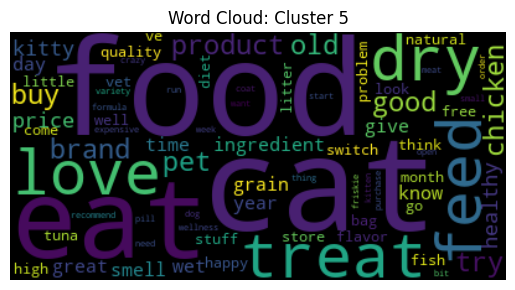

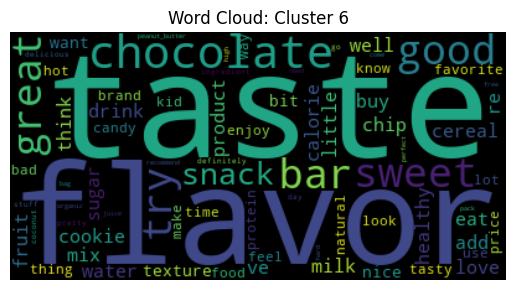

In [77]:
# Frequency and Visualisation
getWordCloud(vectorizer, kmeans, k)

In [78]:
#Evaluation
s_score = silhouette_score(X_vect, kmeans.labels_)
print(f"Silhouette Score: {s_score}")

Silhouette Score: 0.009846888832223698


In [79]:
# Get the inertia (SSE)
inertia = kmeans.inertia_

print("Inertia (SSE):", inertia)

Inertia (SSE): 95301.01633204514


### Using BoW

The model name is BoW



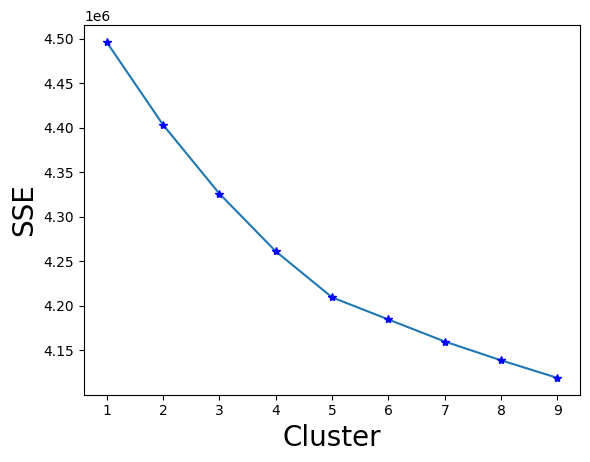

In [80]:
vectorizer = create_feature_engineering('BoW')
X_vect = vectorizer.fit_transform(X)
elbow_diagram(X_vect)

The number of reviews in each cluster are as follows : 
Cluster = 0, Reviews Number = 2255
Cluster = 1, Reviews Number = 77839
Cluster = 2, Reviews Number = 3290
Cluster = 3, Reviews Number = 13206
Cluster = 4, Reviews Number = 3410


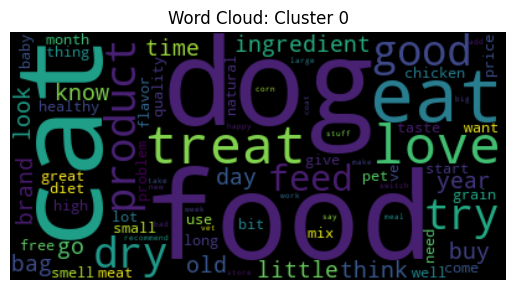

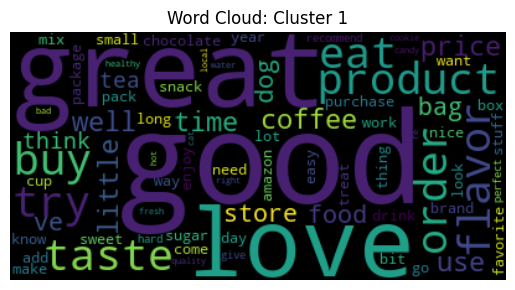

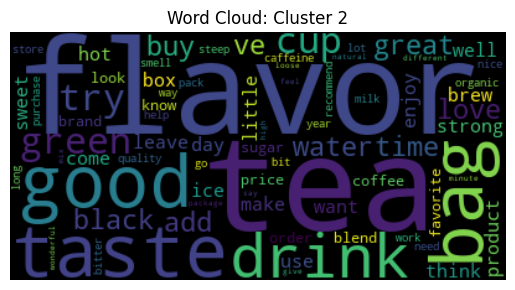

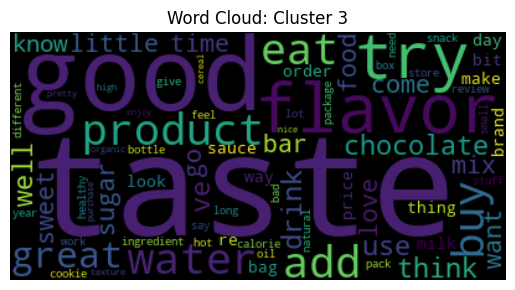

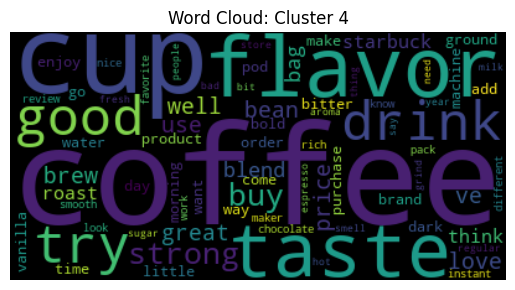

Silhouette Score: 0.21745600274660076
Inertia (SSE): 4209568.323302809


In [88]:
k = 5
kmeans = KMeans(n_clusters = k, random_state = 42)
kmeans.fit(X_vect)
labels = kmeans.predict(X_vect)
#print(labels)

# get the labels of each cluster
get_cluster_reviews_number(k)

# Frequency and Visualisation
getWordCloud(vectorizer, kmeans, k)

#Evaluation
s_score = silhouette_score(X_vect, kmeans.labels_)
print(f"Silhouette Score: {s_score}")

# Get the inertia (SSE)
inertia = kmeans.inertia_
print("Inertia (SSE):", inertia)

## Deep Learning Methods/Models

### Data Preprocessing

In [235]:
embed_size = 200 # represents the dimensionality of the embedding space
embedding_dim = 100

# Hyperparameter tuning
batch_size = 500
epochs = 5
learning_rate = 0.001
dropout = 0.2

accuracy_list=[]
precision_list=[]
recall_list=[]
fscore_list=[]
model_list=[]

X = df['CleanedText']
Y = df['Sentiment_Int']

In [236]:
def reviews_to_integers(review_list):
    '''
        The function transforms list of reviews into a list of integers
    '''
    
    reviews_to_int = []
    for review in review_list:
        list = [word for word in review.split()]
        review_to_int = []
        for word in list:
            review_to_int.append(vocabulary_to_int[word]) #str(vocabulary_to_int[word]) + ""
        reviews_to_int.append(review_to_int)
    return reviews_to_int

In [237]:
def get_cofusion_matrix(y_test, y_pred):
    '''
        The function plots confusion_matrix
    '''    
    
    display_labels = [1, 0]
    con_mat = confusion_matrix(y_test, y_pred, labels = display_labels)
    ax = plt.axes()
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix = con_mat, display_labels = display_labels)
    disp.plot(ax = ax)
    plt.show()
      
    # Print the Conclusions on the trained dataset
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    positive_count = TP + FN
    negative_count = FP + TN
    
    TPR = TP / positive_count
    TNR = TN / negative_count
    FPR = FP / negative_count
    FNR = FN / positive_count
    
    print("*** The Confusion Matrix Information ***")
    print("The True Positives Rate: {}".format(TPR))
    print("The True Negatives Rate: {}".format(TNR))
    print("The False Positives Rate: {}".format(FPR))
    print("The False Negatives Rate: {}".format(FNR))

In [238]:
def get_accuracy_loss_validation_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [260]:
def create_GloVe_embedding_layer(path_to_glove_file, vocabulary_to_int, embedding_dim):    
    embedding_index = {}
    with open(path_to_glove_file, encoding='utf-8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embedding_index[word] = coefs
    
    print('Found %s word vectors.' % len(embedding_index))
    
    num_tokens = len(vocabulary_to_int) + 2  # Corrected variable name
    hits = 0
    misses = 0
    
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))  # Corrected variable name
    for word, i in vocabulary_to_int.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))  # Corrected printing statement

    # Create enbedding layer
    embedding_layer = Embedding(
        num_tokens, 
        embedding_dim, 
        embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
        trainable=False)
    return embedding_layer

In [265]:
def create_Word2Vec_embedding_layer(word2vec_file_path, vocabulary_to_int, embedding_dim):
    word2vec_model = Word2Vec.load(word2vec_file_path)

    num_tokens = len(vocabulary_to_int) + 2  # Including padding and unknown token
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in vocabulary_to_int.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    # Create embedding layer
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=tf.constant_initializer(embedding_matrix),
        trainable=False)
    
    return embedding_layer

In [ ]:
def train_Word2Vec_model(df, embedding_dim=100):
    final_string = []
    for sent in df['CleanedText'].values:
        sent = str(sent)
        sentence=[]
        for word in sent.split():
            sentence.append(word)
        final_string.append(sentence)
        
    #Train Word2Vec model using text corpus
    w2v_model=gensim.models.Word2Vec(final_string, min_count=5, vector_size=embedding_dim, workers=-1)
    w2v_model.save('w2vmodel')#Persist/Saving the model to a file in the disk 
    return w2v_model

In [ ]:
def create_Word2Vec_embedding_layer(word2vec_model, vocabulary_to_int, embedding_dim):
    num_tokens = len(vocabulary_to_int) + 2  # Including padding and unknown token
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in vocabulary_to_int.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    # Create embedding layer
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=tf.constant_initializer(embedding_matrix),
        trainable=False)
    
    return embedding_layer

In [240]:
def create_recurent_model(model_type, x_train, y_train, x_test, y_test, x_val, y_val):
    # According to the input, the vectorizer is created
    print(f"The model name is {model_type}\n")
    
    model = tf.keras.Sequential()
    model.add(Embedding(len(vocabulary_to_int), embed_size, input_length= max_length))
    if model_type == 'RNN':
        model.add(tf.keras.layers.SimpleRNN(256, return_sequences = True, dropout = dropout, recurrent_dropout = dropout))
        model.add(tf.keras.layers.SimpleRNN(128, dropout = dropout, recurrent_dropout = dropout))
    elif model_type == 'LSTM':
        model.add(tf.keras.layers.LSTM(256, return_sequences = True, dropout = dropout, recurrent_dropout = dropout))
        model.add(tf.keras.layers.LSTM(128, dropout = dropout, recurrent_dropout = dropout))
    elif model_type == 'GRU':
        model.add(tf.keras.layers.GRU(256, return_sequences = True, dropout = dropout, recurrent_dropout = dropout))
        model.add(tf.keras.layers.GRU(128, dropout = dropout, recurrent_dropout = dropout))
    else:
        return "Invalid model name."
    model.add(Dense(1, activation='sigmoid'))
                
    # Reshape x_train to include the missing dimension for features
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

    # Build the model
    model.build(input_shape=(x_train.shape))

    # Print model summary
    print(f"*** The model summary for {model_type} ***\n")
    model.summary()

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
 
    # Convert input data to float32
    x_train = np.array(x_train, dtype=np.float32)
    x_val = np.array(x_val, dtype=np.float32)

    # Train the model
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    
    # Plot Accuracy, Lost
    get_accuracy_loss_validation_plot(history)
    
    # Evaluate the model on test data
    loss, accuracy = model.evaluate(x_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)
    print()
    
    # Make predictions on test data
    threshold = 0.5
    y_pred = model.predict(x_test)
    y_pred_class = np.where(y_pred > threshold, 1, 0)
    
    # Evaluateion
    print("*** The Evaluation of the Model ***")
    get_evaluation(y_test, y_pred_class)
    
    # Calculate the confusion matrix
    get_cofusion_matrix(y_test, y_pred_class)

In [241]:
def create_recurent_model_embedding(model_type, embedding_layer, x_train, y_train, x_test, y_test, x_val, y_val):
    print(f"The model name is {model_type}\n")
    
    model = tf.keras.Sequential()
    model.add(embedding_layer)
    if model_type == 'RNN':
        model.add(tf.keras.layers.SimpleRNN(256, return_sequences = True, dropout = dropout, recurrent_dropout = dropout))
        model.add(tf.keras.layers.SimpleRNN(128, dropout = dropout, recurrent_dropout = dropout))
    elif model_type == 'LSTM':
        model.add(tf.keras.layers.LSTM(256, return_sequences = True, dropout = dropout, recurrent_dropout = dropout))
        model.add(tf.keras.layers.LSTM(128, dropout = dropout, recurrent_dropout = dropout))
    elif model_type == 'GRU':
        model.add(tf.keras.layers.GRU(256, return_sequences = True, dropout = dropout, recurrent_dropout = dropout))
        model.add(tf.keras.layers.GRU(128, dropout = dropout, recurrent_dropout = dropout))
    else:
        return "Invalid model name."
    model.add(Dense(1, activation='sigmoid'))
                
    # Reshape x_train to include the missing dimension for features
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

    # Build the model
    model.build(input_shape=(x_train.shape))

    # Print model summary
    print(f"*** The model summary for {model_type} ***\n")
    model.summary()

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
 
    # Convert input data to float32
    x_train = np.array(x_train, dtype=np.float32)
    x_val = np.array(x_val, dtype=np.float32)

    # Train the model
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    
    # Plot Accuracy, Lost
    get_accuracy_loss_validation_plot(history)
    
    # Evaluate the model on test data
    loss, accuracy = model.evaluate(x_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)
    print()
    
    # Make predictions on test data
    threshold = 0.5
    y_pred = model.predict(x_test)
    y_pred_class = np.where(y_pred > threshold, 1, 0)
    
    # Evaluateion
    print("*** The Evaluation of the Model ***")
    get_evaluation(y_test, y_pred_class)
    
    # Calculate the confusion matrix
    get_cofusion_matrix(y_test, y_pred_class)

In [242]:
# Split the text into words
word_list = [' ']

for text in X:
    words = text.split()
    for word in words:
        if word not in word_list:  # Check if the word is not already in the list
            word_list.append(word)

In [243]:
# Store all the text from each review in a text variable
text = ' '.join(word_list)

# List all the vocabulary contained in the reviews
vocabulary = set(text.split(' '))

# Map each word to an integer
vocabulary_to_int = {word:i for i, word in enumerate(vocabulary, 0)}

print(len(vocabulary_to_int))

76452


In [244]:
reviews_to_int = reviews_to_integers(X)

review_lengths = [len(review) for review in reviews_to_int]
print("Shortest review:", min(review_lengths))
print("Longest revies:", max(review_lengths))

Shortest review: 0
Longest revies: 838


[]

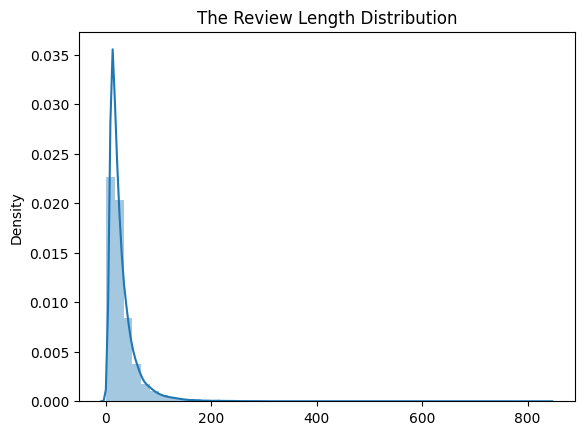

In [245]:
# distribution of the review length
ax = plt.axes()
sns.distplot(review_lengths)
ax.set_title("The Review Length Distribution")
plt.plot()

In [246]:
pd.DataFrame(review_lengths).describe()

0
count  100000.000000
mean       29.685310
std        29.205345
min         0.000000
25%        13.000000
50%        21.000000
75%        36.000000
max       838.000000

In [248]:
# The mean and third quartile are 29 and 36. To minimize information loss, review length is limited to 100 words
max_length = 100
features = np.zeros(shape=(len(reviews_to_int), max_length), dtype=int)


for i in range(len(reviews_to_int)):
    nb_words = len(reviews_to_int[i])
    features[i] = [0]*(max_length -nb_words) + reviews_to_int[i][:100]

In [230]:
## The mean and third quartile are 29 and 36. To minimize information loss, review length is limited to 100 words
#max_length = 100
#features = tf.keras.preprocessing.sequence.pad_sequences(reviews_to_int, maxlen=max_length, padding='post')
#features

array([[71871, 12002, 40088, ...,     0,     0,     0],
       [73574, 32132, 68283, ...,     0,     0,     0],
       [63693, 18298, 32132, ...,     0,     0,     0],
       ...,
       [ 6245,  8325, 50900, ...,     0,     0,     0],
       [74599, 44776, 71564, ...,     0,     0,     0],
       [60142, 71513,  1910, ...,     0,     0,     0]])

In [253]:
# Spliting the data into training, validation and testing datasets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=5435)

# Assuming features and Y are numpy arrays
features = np.array(features)
Y = np.array(Y)

splitter = sss.split(features, Y)
train_index, validation_index = next(splitter)
test_index = validation_index[:int(len(validation_index)/2)]
validation_index = validation_index[int(len(validation_index)/2):]

x_train, y_train = features[train_index], Y[train_index]
x_test, y_test= features[test_index], Y[test_index]
x_val, y_val = features[validation_index], Y[validation_index]

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(x_train.shape), 
      "\nValidation set: \t{}".format(x_val.shape),
      "\nTest set: \t\t{}".format(x_test.shape))

			Feature Shapes:
Train set: 		(124572, 100) 
Validation set: 	(10000, 100) 
Test set: 		(10000, 100)


In [257]:
#import requests
#import zipfile
#import io
#
## Download GloVe embeddings
#url = 'http://nlp.stanford.edu/data/glove.6B.zip'
#r = requests.get(url)
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall()
#
path_to_glove_file = 'glove.6B.100d.txt'

### Standard RNN

The model name is RNN

*** The model summary for RNN ***

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 200)          15290400  
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, 100, 256)          116992    
                                                                 
 simple_rnn_24 (SimpleRNN)   (None, 128)               49280     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 15,456,801
Trainable params: 15,456,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
160/160 [==============================] - 194s 1s/step - loss: 0.4691 - accuracy: 0.7933 - val_loss: 0.3

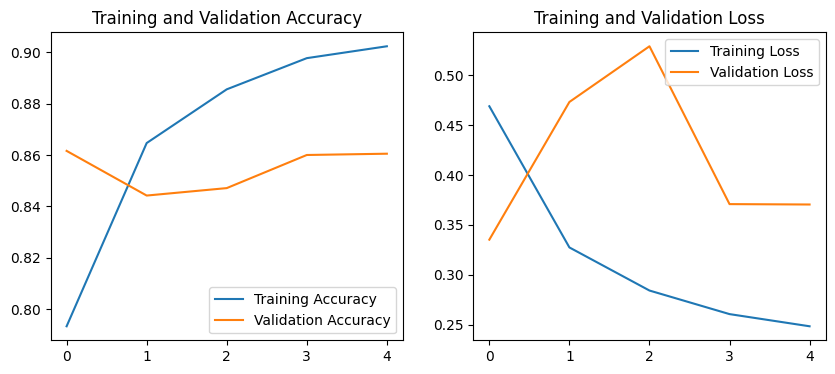

313/313 [==============================] - 14s 44ms/step - loss: 0.3733 - accuracy: 0.8613
Test Loss: 0.3733122646808624
Test Accuracy: 0.861299991607666

313/313 [==============================] - 12s 36ms/step
*** The Evaluation of the Model ***
Accuracy =  0.86
Precision =  0.86
Recall =  0.86
F1_score =  0.86

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.71      0.64      0.67      2229
           1       0.90      0.93      0.91      7771

    accuracy                           0.86     10000
   macro avg       0.80      0.78      0.79     10000
weighted avg       0.86      0.86      0.86     10000



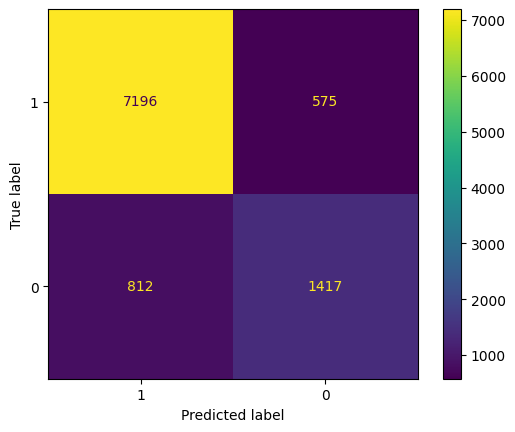

*** The Confusion Matrix Information ***
The True Positives Rate: 0.9260069489126238
The True Negatives Rate: 0.6357110812023329
The False Positives Rate: 0.3642889187976671
The False Negatives Rate: 0.07399305108737614


In [251]:
# Create a Model
create_recurent_model('RNN', x_train_resampled, y_train_resampled, x_test, y_test, x_val, y_val)
model_list.append('RNN')

#### Using GloVe

Found 400000 word vectors.
Converted 25841 words (50611 misses)
The model name is RNN

*** The model summary for RNN ***

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 100)         7645400   
                                                                 
 simple_rnn_31 (SimpleRNN)   (None, None, 256)         91392     
                                                                 
 simple_rnn_32 (SimpleRNN)   (None, 128)               49280     
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 7,786,201
Trainable params: 140,801
Non-trainable params: 7,645,400
_________________________________________________________________
Epoch 1/5
160/160 [============================

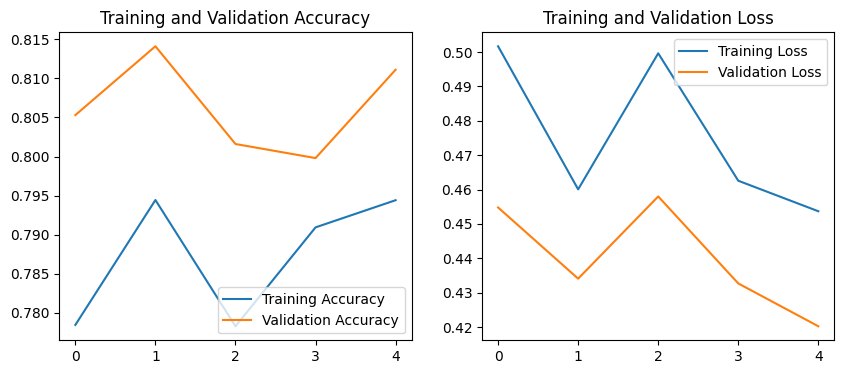

313/313 [==============================] - 11s 34ms/step - loss: 0.4300 - accuracy: 0.8011
Test Loss: 0.43001699447631836
Test Accuracy: 0.8011000156402588

313/313 [==============================] - 10s 32ms/step
*** The Evaluation of the Model ***
Accuracy =  0.80
Precision =  0.78
Recall =  0.80
F1_score =  0.78

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.58      0.38      0.46      2229
           1       0.84      0.92      0.88      7771

    accuracy                           0.80     10000
   macro avg       0.71      0.65      0.67     10000
weighted avg       0.78      0.80      0.78     10000



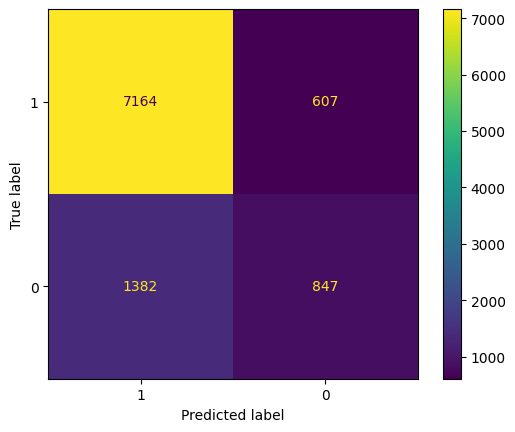

*** The Confusion Matrix Information ***
The True Positives Rate: 0.9218890747651525
The True Negatives Rate: 0.37999102736653206
The False Positives Rate: 0.6200089726334679
The False Negatives Rate: 0.07811092523484751


In [262]:
# Create a Model
glove_embedding_layer = create_GloVe_embedding_layer(path_to_glove_file, vocabulary_to_int, 100)
create_recurent_model_embedding('RNN', glove_embedding_layer, x_train_resampled, y_train_resampled, x_test, y_test, x_val, y_val)
model_list.append('RNN_GloVe')

#### Using Word2Vec

Converted 15021 words (61431 misses)
The model name is RNN

*** The model summary for RNN ***

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 100)         7645400   
                                                                 
 simple_rnn_33 (SimpleRNN)   (None, None, 256)         91392     
                                                                 
 simple_rnn_34 (SimpleRNN)   (None, 128)               49280     
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 7,786,201
Trainable params: 140,801
Non-trainable params: 7,645,400
_________________________________________________________________
Epoch 1/5
160/160 [==============================] - 201s 1s/step - loss: 

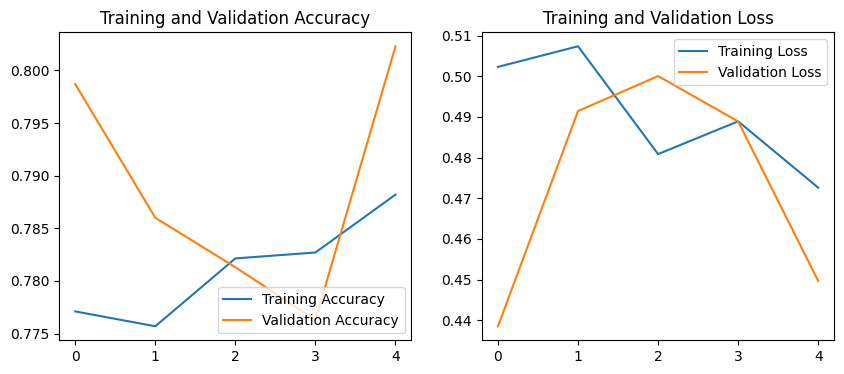

313/313 [==============================] - 18s 56ms/step - loss: 0.4630 - accuracy: 0.8022
Test Loss: 0.46304282546043396
Test Accuracy: 0.8022000193595886

313/313 [==============================] - 18s 56ms/step
*** The Evaluation of the Model ***
Accuracy =  0.80
Precision =  0.79
Recall =  0.80
F1_score =  0.75

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.71      0.19      0.30      2229
           1       0.81      0.98      0.88      7771

    accuracy                           0.80     10000
   macro avg       0.76      0.58      0.59     10000
weighted avg       0.79      0.80      0.75     10000



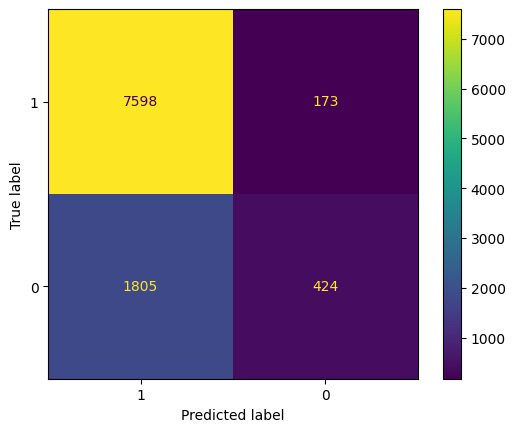

*** The Confusion Matrix Information ***
The True Positives Rate: 0.977737742890233
The True Negatives Rate: 0.1902198295199641
The False Positives Rate: 0.8097801704800359
The False Negatives Rate: 0.02226225710976708


In [299]:
# Train Word2Vec model
word2vec_model = train_Word2Vec_model(df)
# Create a Model
embedding_layer = create_Word2Vec_embedding_layer(word2vec_model, vocabulary_to_int, embedding_dim)
create_recurent_model_embedding('RNN', glove_embedding_layer, x_train_resampled, y_train_resampled, x_test, y_test, x_val, y_val)
model_list.append('RNN_Word2Vec')

### LSTM

The model name is LSTM

*** The model summary for LSTM ***

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 100, 200)          15290400  
                                                                 
 lstm_1 (LSTM)               (None, 100, 256)          467968    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 15,955,617
Trainable params: 15,955,617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
160/160 [==============================] - 1296s 8s/step - loss: 0.3811 - accuracy: 0.8362 - val_loss: 

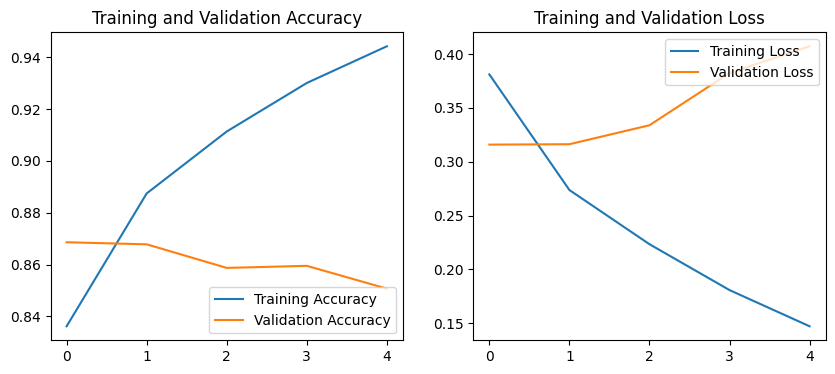

313/313 [==============================] - 2730s 9s/step - loss: 0.4116 - accuracy: 0.8521
Test Loss: 0.41161879897117615
Test Accuracy: 0.8521000146865845

313/313 [==============================] - 117s 372ms/step
*** The Evaluation of the Model ***
Accuracy =  0.85
Precision =  0.85
Recall =  0.85
F1_score =  0.85

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      2229
           1       0.90      0.91      0.91      7771

    accuracy                           0.85     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.85      0.85      0.85     10000



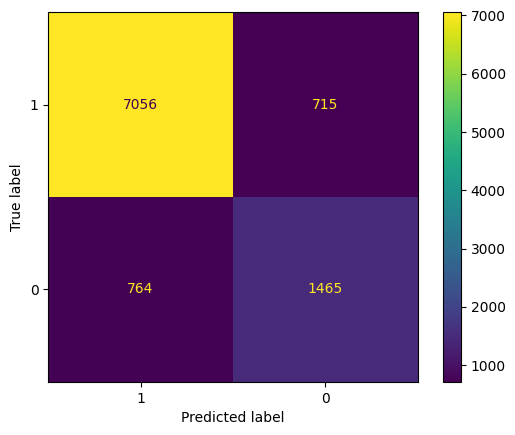

*** The Confusion Matrix Information ***
The True Positives Rate: 0.9079912495174366
The True Negatives Rate: 0.6572454015253477
The False Positives Rate: 0.3427545984746523
The False Negatives Rate: 0.09200875048256338


In [300]:
# Create a Model
create_recurent_model('LSTM', x_train_resampled, y_train_resampled, x_test, y_test, x_val, y_val)
model_list.append('LSTM')

#### Using GloVe

Found 400000 word vectors.
Converted 25841 words (50611 misses)
The model name is LSTM

*** The model summary for LSTM ***

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 100)         7645400   
                                                                 
 lstm_3 (LSTM)               (None, None, 256)         365568    
                                                                 
 lstm_4 (LSTM)               (None, 128)               197120    
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 8,208,217
Trainable params: 562,817
Non-trainable params: 7,645,400
_________________________________________________________________
Epoch 1/5
160/160 [==========================

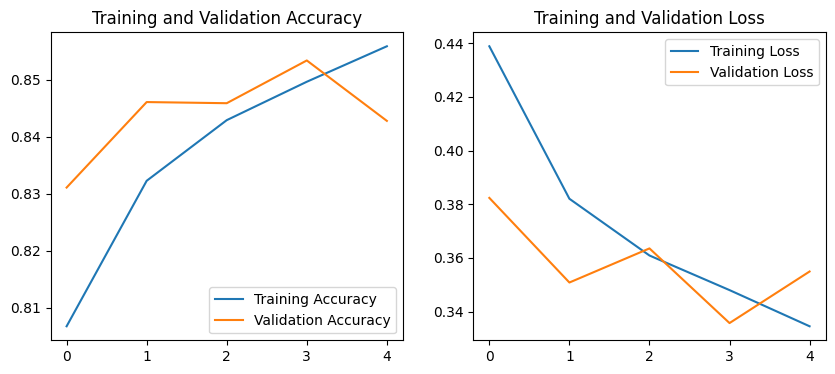

313/313 [==============================] - 89s 284ms/step - loss: 0.3584 - accuracy: 0.8444
Test Loss: 0.35838496685028076
Test Accuracy: 0.8443999886512756

313/313 [==============================] - 88s 280ms/step
*** The Evaluation of the Model ***
Accuracy =  0.84
Precision =  0.85
Recall =  0.84
F1_score =  0.82

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.87      0.36      0.51      2229
           1       0.84      0.98      0.91      7771

    accuracy                           0.84     10000
   macro avg       0.85      0.67      0.71     10000
weighted avg       0.85      0.84      0.82     10000



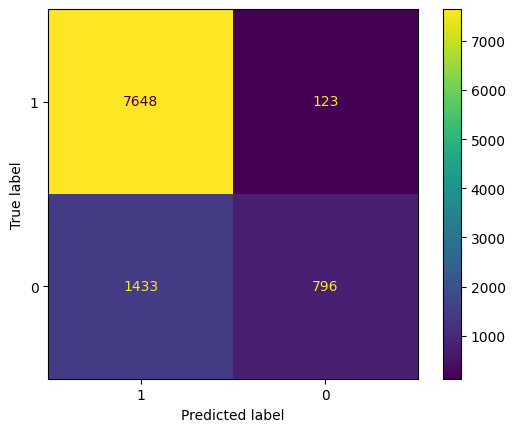

*** The Confusion Matrix Information ***
The True Positives Rate: 0.9841719212456569
The True Negatives Rate: 0.35711081202332884
The False Positives Rate: 0.6428891879766712
The False Negatives Rate: 0.01582807875434307


In [301]:
# Create a Model
glove_embedding_layer = create_GloVe_embedding_layer(path_to_glove_file, vocabulary_to_int, 100)
create_recurent_model_embedding('LSTM', glove_embedding_layer, x_train_resampled, y_train_resampled, x_test, y_test, x_val, y_val)
model_list.append('LSTM_GloVe')

#### Using Word2Vec

Converted 15021 words (61431 misses)
The model name is LSTM

*** The model summary for LSTM ***

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 100)         7645400   
                                                                 
 lstm_5 (LSTM)               (None, None, 256)         365568    
                                                                 
 lstm_6 (LSTM)               (None, 128)               197120    
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 8,208,217
Trainable params: 562,817
Non-trainable params: 7,645,400
_________________________________________________________________
Epoch 1/5
160/160 [==============================] - 1447s 9s/step - los

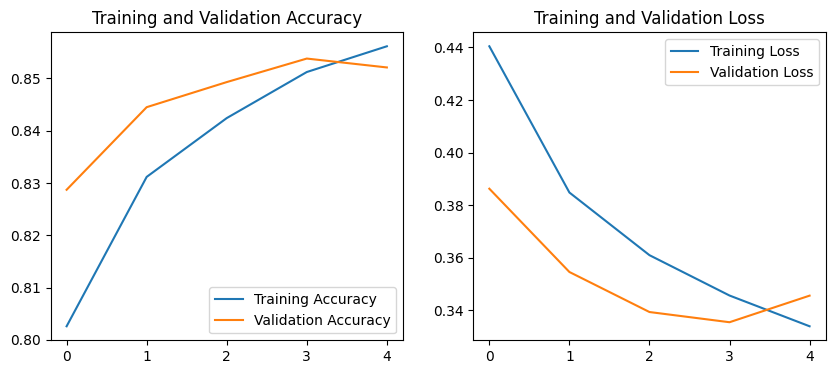

313/313 [==============================] - 99s 314ms/step - loss: 0.3489 - accuracy: 0.8519
Test Loss: 0.3489421606063843
Test Accuracy: 0.8518999814987183

313/313 [==============================] - 97s 308ms/step
*** The Evaluation of the Model ***
Accuracy =  0.85
Precision =  0.85
Recall =  0.85
F1_score =  0.83

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.82      0.43      0.56      2229
           1       0.86      0.97      0.91      7771

    accuracy                           0.85     10000
   macro avg       0.84      0.70      0.74     10000
weighted avg       0.85      0.85      0.83     10000



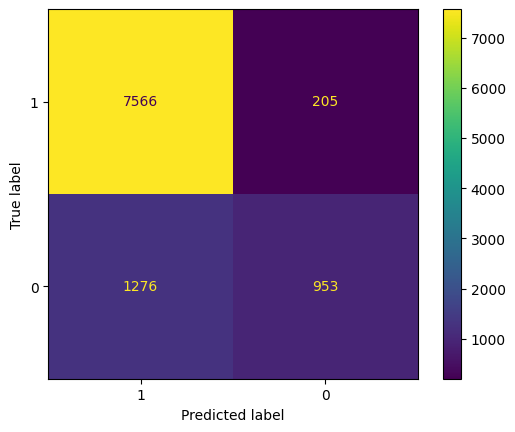

*** The Confusion Matrix Information ***
The True Positives Rate: 0.9736198687427615
The True Negatives Rate: 0.4275459847465231
The False Positives Rate: 0.5724540152534769
The False Negatives Rate: 0.02638013125723845


In [302]:
# Train Word2Vec model
word2vec_model = train_Word2Vec_model(df)
# Create a Model
embedding_layer = create_Word2Vec_embedding_layer(word2vec_model, vocabulary_to_int, embedding_dim)
create_recurent_model_embedding('LSTM', glove_embedding_layer, x_train_resampled, y_train_resampled, x_test, y_test, x_val, y_val)
model_list.append('LSTM_Word2Vec')

### BERT_ After 10 hours waiting for training, 1915 hours are left. Therefore, the process of training is stopped, and the error is shown beacause of stopping the process.

In [313]:
#!pip install transformers

In [ ]:
def create_BERT(df):
    reviews = df['CleanedText'].values.tolist()
    labels = df['Sentiment_Int'].tolist()

    training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(reviews, labels, test_size=.2)
    
    
    #Assign tokenizer object to the tokenizer class
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    #tokenizer([x_train[0]], truncation=True, padding=True, max_length=128)
    
    # Tokenize training and validation sentences
    train_encodings = tokenizer(training_sentences, truncation=True, padding=True)
    val_encodings = tokenizer(validation_sentences, truncation=True, padding=True)

    # Create TensorFlow Dataset objects
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        training_labels
    ))
    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        validation_labels
    ))
    
    #Create Model
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    model.summary()

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Train model
    history = model.fit(train_dataset.shuffle(len(training_sentences)).batch(16),
                        epochs=1,
                        batch_size=16,
                        validation_data=val_dataset.shuffle(len(validation_sentences)).batch(16),
                        verbose=1)

In [388]:
create_BERT(df)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_613 (Dropout)       multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________
  20/5000 [..............................] - ETA: 1915:55:55 - loss: 0.5320

KeyboardInterrupt: 

In [ ]:
# close cursor & connection
cur.close()
con.close()